In [2]:
import os
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, BatchNormalization, ReLU, LSTM
from tensorflow.keras.layers import TimeDistributed
from tensorflow import keras
from tensorflow.keras import layers

import time
import itertools
import pandas as pd
import glob
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt
import gc


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    print(e)

total_df = pd.read_csv("to_mrmr.csv")

print(total_df.shape)

assert(False)

window_n = 5
stride = 12
window_size = 24
normal_scores = []
feature = ['flux',
           'zero_month',
           'zero_week',
           'continuous_zero',
           'diff_week_day',
           'diff_month',
           'std_week',
           'diff_std',
           'rec_day',
           'rec_week',
           'rec_2week',
           'rec_month',
           'rec_day2',
           'rec_week2',
           'rec_2week2',
           'rec_month2', ]







total_data = total_df.dropna().loc[:, ['label'] + feature].to_numpy()

del total_df
gc.collect()


where_abnormal = np.argwhere(total_data[:,0]==1)


#assert(False)




normal_data = []

for i in range(0,total_data.shape[0]-(window_size + (window_n-1)*stride )):
  ws = []
  for w_n in range(window_n):
    ws.append(total_data[(w_n*stride)+ i:(w_n*stride) + i +window_size])
  ws = np.array(ws)
  if np.all(ws[:,:,0] == 0):
    normal_data.append(ws[:, :, 1:])
  #if i == 1000:
  #  break;

normal_data = np.array(normal_data).astype(np.float32)

#print(normal_data.shape)
    
#assert(False)
#good_score.append(kl_divergence(w_p, normal_q))
abnormal_data = []

print(where_abnormal.shape)
for ab in where_abnormal:
  i = ab[0] + 1 - window_size - stride * (window_n-1)
  if (i < 0):
    continue
  ws = []
  for w_n in range(window_n):
    ws.append(total_data[(w_n*stride)+ i:(w_n*stride) + i +window_size, 1:])
  ws = np.array(ws)
  abnormal_data.append(ws)

abnormal_data = np.array(abnormal_data).astype(np.float32)

del total_data
gc.collect()

random_idx = np.arange(normal_data.shape[0])
np.random.shuffle(random_idx)
normal_data = normal_data[random_idx]

random_idx = np.arange(abnormal_data.shape[0])
np.random.shuffle(random_idx)
abnormal_data = abnormal_data[random_idx]

del random_idx

cut = normal_data.shape[0]//5

training_x = normal_data[:cut]
training_y = [[1, 0] for _ in range(cut)]
duplicate_weight = 200

print(training_x.shape)
print(abnormal_data.shape)

for _ in range(duplicate_weight):
  training_x = np.concatenate([training_x, abnormal_data[:abnormal_data.shape[0]//2]], axis = 0)
training_y = training_y + [[0, 1] for _ in range(training_x.shape[0]-len(training_y))]

training_y = np.array(training_y)


test_x = normal_data[cut:]
test_y = [[1, 0] for _ in range(normal_data.shape[0]-cut)]


test_x = np.concatenate([test_x, abnormal_data[abnormal_data.shape[0]//2:]], axis = 0)
test_y = test_y + [[0, 1] for _ in range(test_x.shape[0]-len(test_y))]

test_y = np.array(test_y)

print(training_x.shape)
print(training_y.shape)
print(test_x.shape)
print(test_y.shape)

del normal_data, abnormal_data
gc.collect()


def get_data():
    global training_x, training_y
    random_idx = np.arange(training_x.shape[0])
    np.random.shuffle(random_idx)
    training_x = training_x[random_idx]
    training_y = training_y[random_idx]
    for i in range(training_x.shape[0]):
      x = training_x[i].astype(np.float32)
      y = training_y[i].astype(np.int8)
      yield (x, y)

training_set = tf.data.Dataset.from_generator(get_data, (tf.float32, np.int8), ((window_n, window_size, len(feature)), (2)))

training_set = training_set.batch(256)



def get_test_data():
    global test_x, test_y
    for i in range(test_x.shape[0]):
      x = test_x[i].astype(np.float32)
      y = test_y[i].astype(np.int8)
      yield (x, y)

test_set = tf.data.Dataset.from_generator(get_test_data, (tf.float32, np.int8), ((window_n, window_size, len(feature)), (2)))

test_set = test_set.batch(256)

(2856592, 24)


AssertionError: 

Epoch 1/10
716/716 [==============================] - 13s 18ms/step - loss: 0.3310 - accuracy: 0.8747
Epoch 2/10
716/716 [==============================] - 12s 17ms/step - loss: 0.2321 - accuracy: 0.9196
Epoch 3/10
716/716 [==============================] - 12s 17ms/step - loss: 0.2000 - accuracy: 0.9378
Epoch 4/10
716/716 [==============================] - 12s 17ms/step - loss: 0.1864 - accuracy: 0.9437
Epoch 5/10
716/716 [==============================] - 12s 16ms/step - loss: 0.1782 - accuracy: 0.9470
Epoch 6/10
716/716 [==============================] - 12s 17ms/step - loss: 0.1717 - accuracy: 0.9516
Epoch 7/10
716/716 [==============================] - 11s 16ms/step - loss: 0.1695 - accuracy: 0.9500
Epoch 8/10
716/716 [==============================] - 11s 16ms/step - loss: 0.1655 - accuracy: 0.9498
Epoch 9/10
716/716 [==============================] - 12s 17ms/step - loss: 0.1539 - accuracy: 0.9577
Epoch 10/10
716/716 [==============================] - 12s 16ms/step - loss: 0.148

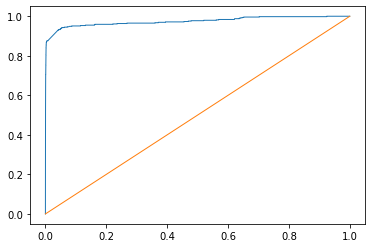

0.974579614074424


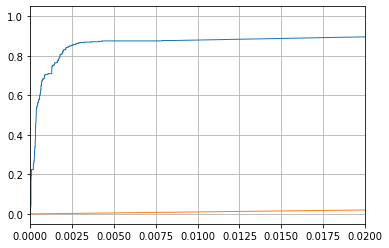

1%
fpr: 0.008599206767049243
tpr:  0.8773006134969326

429 84738 735 60
precision:  0.36855670103092786
recall:  0.8773006134969326
F-measure: 0.5190562613430127
MCC: 0.5652884776172344
0.5%
fpr: 0.004305453184046424
tpr:  0.8752556237218814

428 85105 368 61
precision:  0.5376884422110553
recall:  0.8752556237218814
F-measure: 0.666147859922179
MCC: 0.6838684258603424
0.1%
fpr: 0.000877470078270331
tpr:  0.7055214723926381

345 85398 75 144
precision:  0.8214285714285714
recall:  0.7055214723926381
F-measure: 0.759075907590759
MCC: 0.7600187695239744
Epoch 1/10
716/716 [==============================] - 13s 18ms/step - loss: 0.3138 - accuracy: 0.8860
Epoch 2/10
716/716 [==============================] - 12s 17ms/step - loss: 0.2437 - accuracy: 0.9096
Epoch 3/10
716/716 [==============================] - 12s 16ms/step - loss: 0.2115 - accuracy: 0.9385
Epoch 4/10
716/716 [==============================] - 12s 17ms/step - loss: 0.1936 - accuracy: 0.9455
Epoch 5/10
716/716 [==============

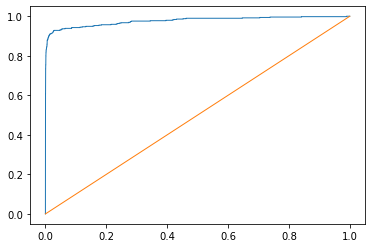

0.9770165045960889


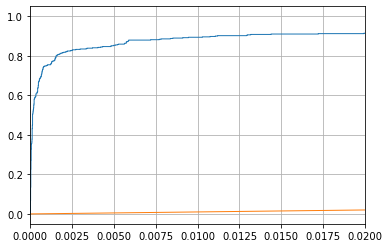

1%
fpr: 0.009827664876627708
tpr:  0.8936605316973415

437 84633 840 52
precision:  0.3422083007047768
recall:  0.8936605316973415
F-measure: 0.49490373725934317
MCC: 0.5494654079123957
0.5%
fpr: 0.004972330443531876
tpr:  0.852760736196319

417 85048 425 72
precision:  0.49524940617577196
recall:  0.852760736196319
F-measure: 0.6265965439519158
MCC: 0.6474176320264886
0.1%
fpr: 0.0009593672855755618
tpr:  0.7505112474437627

367 85391 82 122
precision:  0.8173719376391982
recall:  0.7505112474437627
F-measure: 0.7825159914712153
MCC: 0.7820443077119471
Epoch 1/10
716/716 [==============================] - 13s 19ms/step - loss: 0.3079 - accuracy: 0.8886
Epoch 2/10
716/716 [==============================] - 11s 15ms/step - loss: 0.2601 - accuracy: 0.8960
Epoch 3/10
716/716 [==============================] - 11s 16ms/step - loss: 0.2422 - accuracy: 0.9062
Epoch 4/10
716/716 [==============================] - 11s 15ms/step - loss: 0.2256 - accuracy: 0.9247
Epoch 5/10
716/716 [============

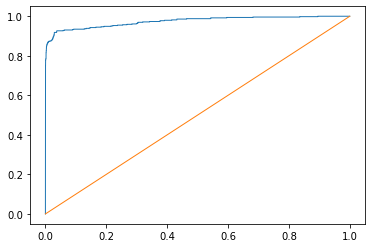

0.9741716592740262


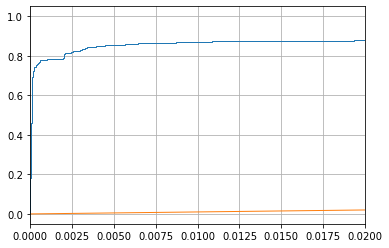

1%
fpr: 0.009347981233839927
tpr:  0.8711656441717791

426 84674 799 63
precision:  0.34775510204081633
recall:  0.8711656441717791
F-measure: 0.49708284714119017
MCC: 0.5468644693269635
0.5%
fpr: 0.004995729645619084
tpr:  0.8568507157464212

419 85046 427 70
precision:  0.49527186761229314
recall:  0.8568507157464212
F-measure: 0.6277153558052435
MCC: 0.648998642787107
0.1%
fpr: 0.0006317784563546383
tpr:  0.7791411042944786

381 85419 54 108
precision:  0.8758620689655172
recall:  0.7791411042944786
F-measure: 0.8246753246753247
MCC: 0.8251567845443386
Epoch 1/10
716/716 [==============================] - 14s 19ms/step - loss: 0.3873 - accuracy: 0.8715
Epoch 2/10
716/716 [==============================] - 12s 16ms/step - loss: 0.2864 - accuracy: 0.8870
Epoch 3/10
716/716 [==============================] - 13s 17ms/step - loss: 0.2543 - accuracy: 0.9002
Epoch 4/10
716/716 [==============================] - 11s 16ms/step - loss: 0.2244 - accuracy: 0.9312
Epoch 5/10
716/716 [==========

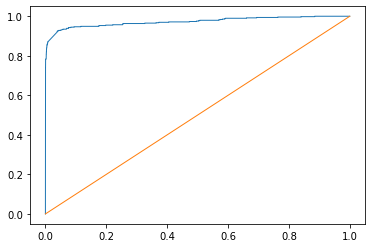

0.9725770443252426


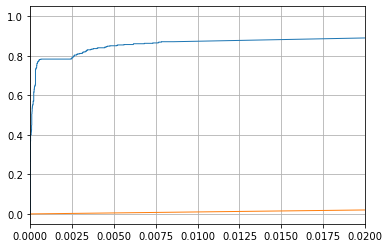

1%
fpr: 0.008552408362874827
tpr:  0.8711656441717791

426 84742 731 63
precision:  0.3681936041486603
recall:  0.8711656441717791
F-measure: 0.5176184690157958
MCC: 0.5629989853735285
0.5%
fpr: 0.004761737624746996
tpr:  0.8507157464212679

416 85066 407 73
precision:  0.5054678007290401
recall:  0.8507157464212679
F-measure: 0.6341463414634146
MCC: 0.6533583804310188
0.1%
fpr: 0.0006317784563546383
tpr:  0.7832310838445807

383 85419 54 106
precision:  0.8764302059496567
recall:  0.7832310838445807
F-measure: 0.8272138228941686
MCC: 0.8276011804824503
Epoch 1/10
716/716 [==============================] - 13s 19ms/step - loss: 0.3351 - accuracy: 0.8822
Epoch 2/10
716/716 [==============================] - 12s 16ms/step - loss: 0.2620 - accuracy: 0.8993
Epoch 3/10
716/716 [==============================] - 11s 16ms/step - loss: 0.2273 - accuracy: 0.9301
Epoch 4/10
716/716 [==============================] - 11s 16ms/step - loss: 0.2061 - accuracy: 0.9412
Epoch 5/10
716/716 [============

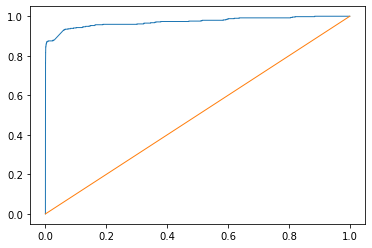

0.9718339761055866


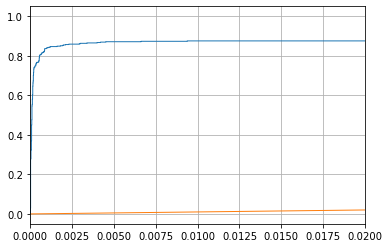

1%
fpr: 0.00938308003697074
tpr:  0.8752556237218814

428 84671 802 61
precision:  0.34796747967479674
recall:  0.8752556237218814
F-measure: 0.49796393251890636
MCC: 0.5483357825781916
0.5%
fpr: 0.004516046002831303
tpr:  0.8711656441717791

426 85087 386 63
precision:  0.5246305418719212
recall:  0.8711656441717791
F-measure: 0.654880860876249
MCC: 0.6738172152408213
0.1%
fpr: 0.0009944660887063752
tpr:  0.8404907975460123

411 85388 85 78
precision:  0.8286290322580645
recall:  0.8404907975460123
F-measure: 0.834517766497462
MCC: 0.8335855515452989
Epoch 1/10
716/716 [==============================] - 13s 18ms/step - loss: 0.3799 - accuracy: 0.8777
Epoch 2/10
716/716 [==============================] - 12s 17ms/step - loss: 0.3271 - accuracy: 0.8828
Epoch 3/10
716/716 [==============================] - 12s 16ms/step - loss: 0.3042 - accuracy: 0.8831
Epoch 4/10
716/716 [==============================] - 13s 18ms/step - loss: 0.2550 - accuracy: 0.9043
Epoch 5/10
716/716 [==============

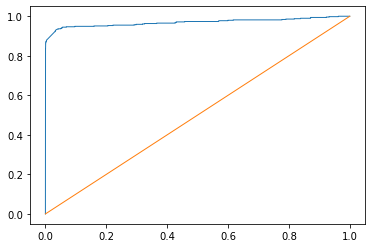

0.9691112947158931


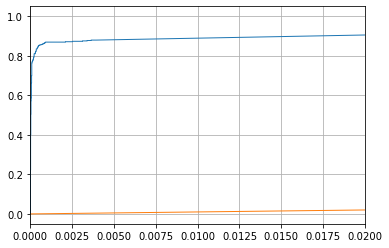

1%
fpr: 0.003931065950651083
tpr:  0.8793456032719836

430 85137 336 59
precision:  0.5613577023498695
recall:  0.8793456032719836
F-measure: 0.6852589641434262
MCC: 0.7005815088339112
0.5%
fpr: 0.003931065950651083
tpr:  0.8793456032719836

430 85137 336 59
precision:  0.5613577023498695
recall:  0.8793456032719836
F-measure: 0.6852589641434262
MCC: 0.7005815088339112
0.1%
fpr: 0.0009125688814011442
tpr:  0.869120654396728

425 85395 78 64
precision:  0.8449304174950298
recall:  0.869120654396728
F-measure: 0.8568548387096775
MCC: 0.8561105195135967
Epoch 1/10
716/716 [==============================] - 13s 18ms/step - loss: 0.4190 - accuracy: 0.8662
Epoch 2/10
716/716 [==============================] - 12s 16ms/step - loss: 0.3229 - accuracy: 0.8868
Epoch 3/10
716/716 [==============================] - 11s 16ms/step - loss: 0.2840 - accuracy: 0.8923
Epoch 4/10
716/716 [==============================] - 11s 16ms/step - loss: 0.2580 - accuracy: 0.8960
Epoch 5/10
716/716 [===============

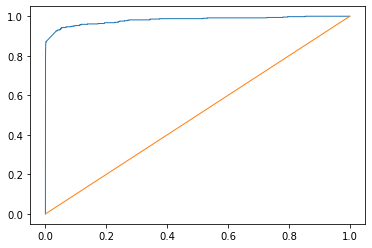

0.9807367265095279


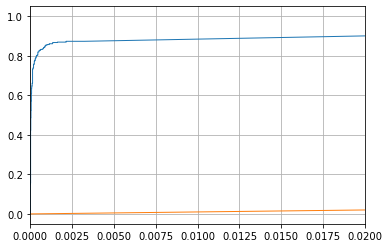

1%
fpr: 0.0032407894890784223
tpr:  0.8732106339468303

427 85196 277 62
precision:  0.6065340909090909
recall:  0.8732106339468303
F-measure: 0.7158424140821459
MCC: 0.7259708828552416
0.5%
fpr: 0.0032407894890784223
tpr:  0.8732106339468303

427 85196 277 62
precision:  0.6065340909090909
recall:  0.8732106339468303
F-measure: 0.7158424140821459
MCC: 0.7259708828552416
0.1%
fpr: 0.0009476676845319575
tpr:  0.8548057259713702

418 85392 81 71
precision:  0.8376753507014028
recall:  0.8548057259713702
F-measure: 0.8461538461538461
MCC: 0.8453085174832863
Epoch 1/10
716/716 [==============================] - 17s 24ms/step - loss: 0.4088 - accuracy: 0.8785
Epoch 2/10
716/716 [==============================] - 11s 16ms/step - loss: 0.3281 - accuracy: 0.8878
Epoch 3/10
716/716 [==============================] - 13s 18ms/step - loss: 0.2872 - accuracy: 0.8911
Epoch 4/10
716/716 [==============================] - 11s 16ms/step - loss: 0.2495 - accuracy: 0.9113
Epoch 5/10
716/716 [===========

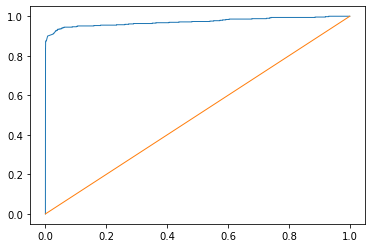

0.9720693558092002


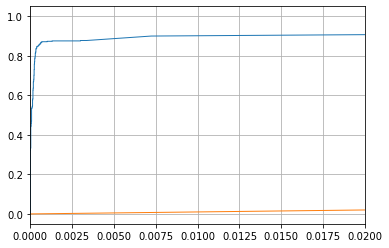

1%
fpr: 0.007230353444947527
tpr:  0.8997955010224948

440 84855 618 49
precision:  0.4158790170132325
recall:  0.8997955010224948
F-measure: 0.5688429217840982
MCC: 0.6088382353772789
0.5%
fpr: 0.003369485100558071
tpr:  0.8773006134969326

429 85185 288 60
precision:  0.5983263598326359
recall:  0.8773006134969326
F-measure: 0.7114427860696517
MCC: 0.7226900519782392
0.1%
fpr: 0.0007019760626162648
tpr:  0.8711656441717791

426 85413 60 63
precision:  0.8765432098765432
recall:  0.8711656441717791
F-measure: 0.8738461538461538
MCC: 0.8731308283141187
Epoch 1/10
716/716 [==============================] - 13s 18ms/step - loss: 0.4101 - accuracy: 0.8783
Epoch 2/10
716/716 [==============================] - 12s 16ms/step - loss: 0.3009 - accuracy: 0.8946
Epoch 3/10
716/716 [==============================] - 12s 16ms/step - loss: 0.2671 - accuracy: 0.9002
Epoch 4/10
716/716 [==============================] - 12s 16ms/step - loss: 0.2342 - accuracy: 0.9254
Epoch 5/10
716/716 [=============

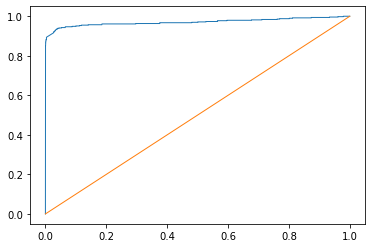

0.9707868378866196


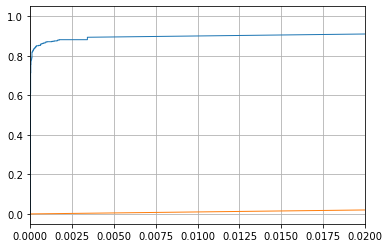

1%
fpr: 0.0034162835047324884
tpr:  0.8936605316973415

437 85181 292 52
precision:  0.5994513031550068
recall:  0.8936605316973415
F-measure: 0.7175697865353037
MCC: 0.7301472067419654
0.5%
fpr: 0.0034162835047324884
tpr:  0.8936605316973415

437 85181 292 52
precision:  0.5994513031550068
recall:  0.8936605316973415
F-measure: 0.7175697865353037
MCC: 0.7301472067419654
0.1%
fpr: 0.0009944660887063752
tpr:  0.8711656441717791

426 85388 85 63
precision:  0.8336594911937377
recall:  0.8711656441717791
F-measure: 0.852
MCC: 0.8513430067484588
Epoch 1/10
716/716 [==============================] - 14s 20ms/step - loss: 0.3220 - accuracy: 0.8834
Epoch 2/10
716/716 [==============================] - 13s 18ms/step - loss: 0.2363 - accuracy: 0.9152
Epoch 3/10
716/716 [==============================] - 12s 16ms/step - loss: 0.2044 - accuracy: 0.9347
Epoch 4/10
716/716 [==============================] - 13s 18ms/step - loss: 0.1930 - accuracy: 0.9387
Epoch 5/10
716/716 [========================

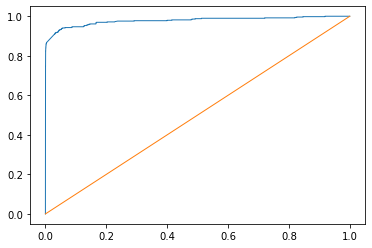

0.9779206875671307


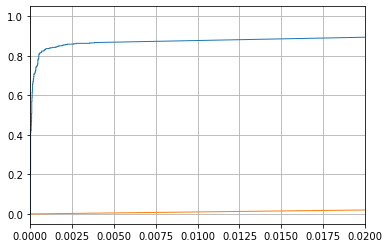

1%
fpr: 0.003919366349607478
tpr:  0.8670756646216768

424 85138 335 65
precision:  0.5586297760210803
recall:  0.8670756646216768
F-measure: 0.6794871794871794
MCC: 0.693920976409196
0.5%
fpr: 0.003919366349607478
tpr:  0.8670756646216768

424 85138 335 65
precision:  0.5586297760210803
recall:  0.8670756646216768
F-measure: 0.6794871794871794
MCC: 0.693920976409196
0.1%
fpr: 0.0009359680834883531
tpr:  0.83640081799591

409 85393 80 80
precision:  0.83640081799591
recall:  0.83640081799591
F-measure: 0.8364008179959099
MCC: 0.8354648499124216
Epoch 1/10
716/716 [==============================] - 14s 19ms/step - loss: 0.3244 - accuracy: 0.8964
Epoch 2/10
716/716 [==============================] - 12s 16ms/step - loss: 0.2231 - accuracy: 0.9214
Epoch 3/10
716/716 [==============================] - 12s 16ms/step - loss: 0.2069 - accuracy: 0.9299
Epoch 4/10
716/716 [==============================] - 12s 17ms/step - loss: 0.1949 - accuracy: 0.9353
Epoch 5/10
716/716 [=====================

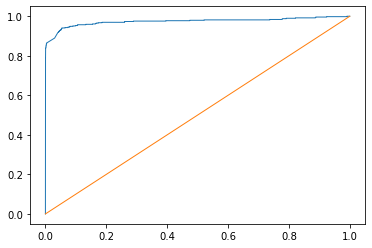

0.9738320119602941


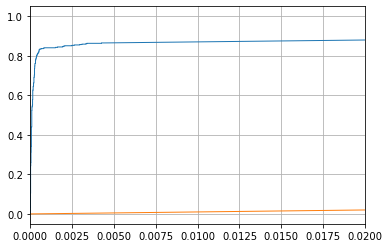

1%
fpr: 0.00448094719970049
tpr:  0.8650306748466258

423 85090 383 66
precision:  0.5248138957816377
recall:  0.8650306748466258
F-measure: 0.6532818532818533
MCC: 0.6715366614031255
0.5%
fpr: 0.00448094719970049
tpr:  0.8650306748466258

423 85090 383 66
precision:  0.5248138957816377
recall:  0.8650306748466258
F-measure: 0.6532818532818533
MCC: 0.6715366614031255
0.1%
fpr: 0.0008306716740959134
tpr:  0.8404907975460123

411 85402 71 78
precision:  0.8526970954356846
recall:  0.8404907975460123
F-measure: 0.8465499485066942
MCC: 0.8457006358817099
Epoch 1/10
716/716 [==============================] - 15s 20ms/step - loss: 0.4034 - accuracy: 0.8726
Epoch 2/10
716/716 [==============================] - 12s 16ms/step - loss: 0.3243 - accuracy: 0.8911
Epoch 3/10
716/716 [==============================] - 13s 18ms/step - loss: 0.3135 - accuracy: 0.8890
Epoch 4/10
716/716 [==============================] - 12s 16ms/step - loss: 0.2838 - accuracy: 0.8924
Epoch 5/10
716/716 [===============

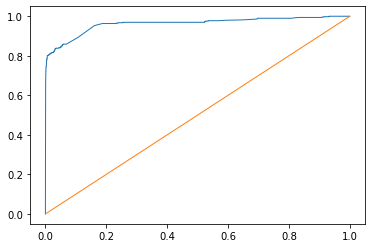

0.9618542642665211


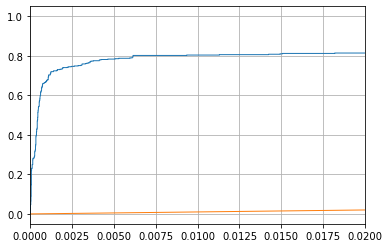

1%
fpr: 0.009897862482889333
tpr:  0.803680981595092

393 84627 846 96
precision:  0.3171912832929782
recall:  0.803680981595092
F-measure: 0.4548611111111111
MCC: 0.5008808711668157
0.5%
fpr: 0.004995729645619084
tpr:  0.7832310838445807

383 85046 427 106
precision:  0.4728395061728395
recall:  0.7832310838445807
F-measure: 0.5896843725943033
MCC: 0.6058148625564465
0.1%
fpr: 0.0009944660887063752
tpr:  0.6768916155419223

331 85388 85 158
precision:  0.7956730769230769
recall:  0.6768916155419223
F-measure: 0.7314917127071822
MCC: 0.7324921910212602
Epoch 1/10
716/716 [==============================] - 14s 19ms/step - loss: 0.4162 - accuracy: 0.8634
Epoch 2/10
716/716 [==============================] - 12s 16ms/step - loss: 0.3360 - accuracy: 0.8771
Epoch 3/10
716/716 [==============================] - 12s 16ms/step - loss: 0.3185 - accuracy: 0.8803
Epoch 4/10
716/716 [==============================] - 12s 16ms/step - loss: 0.2989 - accuracy: 0.8867
Epoch 5/10
716/716 [=============

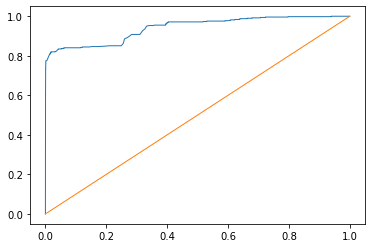

0.9411288875662838


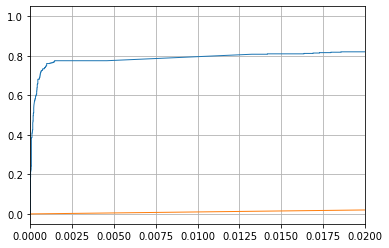

1%
fpr: 0.004574544008049326
tpr:  0.7750511247443763

379 85082 391 110
precision:  0.4922077922077922
recall:  0.7750511247443763
F-measure: 0.602065131056394
MCC: 0.6150119808431759
0.5%
fpr: 0.004574544008049326
tpr:  0.7750511247443763

379 85082 391 110
precision:  0.4922077922077922
recall:  0.7750511247443763
F-measure: 0.602065131056394
MCC: 0.6150119808431759
0.1%
fpr: 0.0009827664876627708
tpr:  0.7607361963190185

372 85389 84 117
precision:  0.8157894736842105
recall:  0.7607361963190185
F-measure: 0.7873015873015873
MCC: 0.78661252279465
Epoch 1/10
716/716 [==============================] - 14s 19ms/step - loss: 0.3797 - accuracy: 0.8779
Epoch 2/10
716/716 [==============================] - 13s 18ms/step - loss: 0.2911 - accuracy: 0.8908
Epoch 3/10
716/716 [==============================] - 12s 16ms/step - loss: 0.2710 - accuracy: 0.8933
Epoch 4/10
716/716 [==============================] - 13s 18ms/step - loss: 0.2619 - accuracy: 0.8939
Epoch 5/10
716/716 [==============

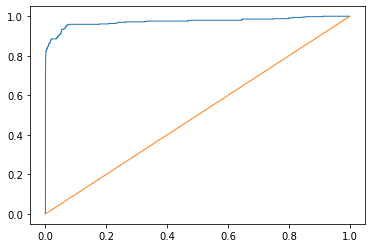

0.9734466548555725


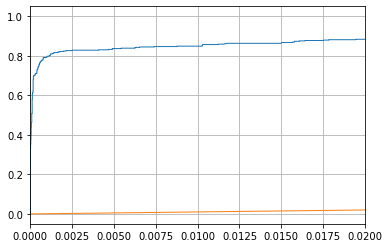

1%
fpr: 0.009991459291238168
tpr:  0.8486707566462167

415 84619 854 74
precision:  0.32702915681639083
recall:  0.8486707566462167
F-measure: 0.4721274175199089
MCC: 0.5230103177330596
0.5%
fpr: 0.004925532039357458
tpr:  0.83640081799591

409 85052 421 80
precision:  0.4927710843373494
recall:  0.83640081799591
F-measure: 0.6201667930250191
MCC: 0.6394885664955591
0.1%
fpr: 0.0009593672855755618
tpr:  0.7934560327198364

388 85391 82 101
precision:  0.825531914893617
recall:  0.7934560327198364
F-measure: 0.8091762252346194
MCC: 0.8082666865017648
Epoch 1/10
716/716 [==============================] - 14s 19ms/step - loss: 0.4045 - accuracy: 0.8805
Epoch 2/10
716/716 [==============================] - 12s 16ms/step - loss: 0.3095 - accuracy: 0.8906
Epoch 3/10
716/716 [==============================] - 12s 16ms/step - loss: 0.2762 - accuracy: 0.8982
Epoch 4/10
716/716 [==============================] - 12s 17ms/step - loss: 0.2561 - accuracy: 0.9055
Epoch 5/10
716/716 [================

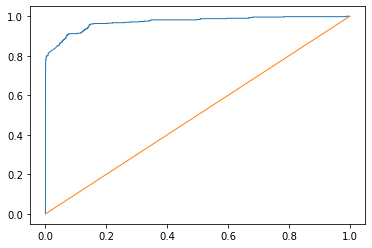

0.9708346172389387


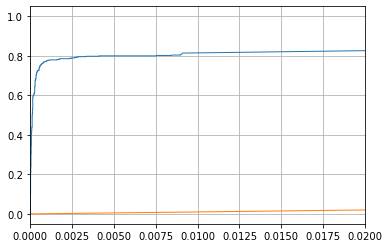

1%
fpr: 0.009289483228621904
tpr:  0.8139059304703476

398 84679 794 91
precision:  0.3338926174496644
recall:  0.8139059304703476
F-measure: 0.4735276621058893
MCC: 0.5174859819396778
0.5%
fpr: 0.004106559966305149
tpr:  0.7995910020449898

391 85122 351 98
precision:  0.5269541778975741
recall:  0.7995910020449898
F-measure: 0.6352558895207149
MCC: 0.6467372504355499
0.1%
fpr: 0.0009710668866191662
tpr:  0.7750511247443763

379 85390 83 110
precision:  0.8203463203463204
recall:  0.7750511247443763
F-measure: 0.7970557308096741
MCC: 0.7962523686903418
Epoch 1/10
716/716 [==============================] - 15s 20ms/step - loss: 0.4453 - accuracy: 0.8653
Epoch 2/10
716/716 [==============================] - 12s 17ms/step - loss: 0.3384 - accuracy: 0.8830
Epoch 3/10
716/716 [==============================] - 13s 18ms/step - loss: 0.3142 - accuracy: 0.8904
Epoch 4/10
716/716 [==============================] - 11s 16ms/step - loss: 0.3068 - accuracy: 0.8926
Epoch 5/10
716/716 [============

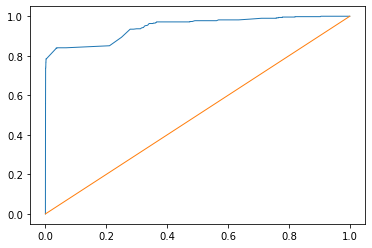

0.9452580093399185


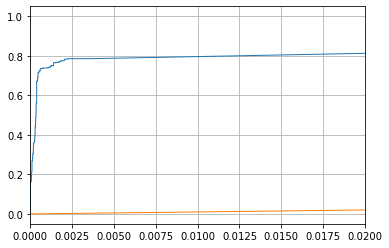

1%
fpr: 0.003591777520386555
tpr:  0.7852760736196319

384 85166 307 105
precision:  0.5557163531114327
recall:  0.7852760736196319
F-measure: 0.6508474576271186
MCC: 0.6583556828248415
0.5%
fpr: 0.003591777520386555
tpr:  0.7852760736196319

384 85166 307 105
precision:  0.5557163531114327
recall:  0.7852760736196319
F-measure: 0.6508474576271186
MCC: 0.6583556828248415
0.1%
fpr: 0.0007604740678342868
tpr:  0.7382413087934561

361 85408 65 128
precision:  0.8474178403755869
recall:  0.7382413087934561
F-measure: 0.789071038251366
MCC: 0.7898422729127391
Epoch 1/10
716/716 [==============================] - 14s 20ms/step - loss: 0.4348 - accuracy: 0.8790
Epoch 2/10
716/716 [==============================] - 12s 16ms/step - loss: 0.3267 - accuracy: 0.8889
Epoch 3/10
716/716 [==============================] - 12s 17ms/step - loss: 0.2920 - accuracy: 0.8941
Epoch 4/10
716/716 [==============================] - 11s 16ms/step - loss: 0.2760 - accuracy: 0.8959
Epoch 5/10
716/716 [===========

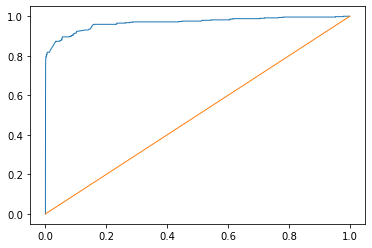

0.9676488565482247


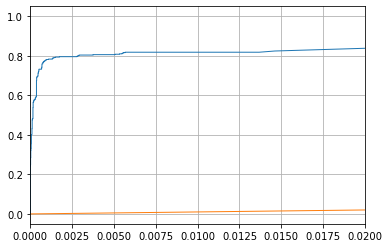

1%
fpr: 0.009944660887063752
tpr:  0.8179959100204499

400 84623 850 89
precision:  0.32
recall:  0.8179959100204499
F-measure: 0.46003450258769407
MCC: 0.5076686380678952
0.5%
fpr: 0.0037555719349970165
tpr:  0.8057259713701431

394 85152 321 95
precision:  0.551048951048951
recall:  0.8057259713701431
F-measure: 0.654485049833887
MCC: 0.6641018179286822
0.1%
fpr: 0.0009593672855755618
tpr:  0.7811860940695297

382 85391 82 107
precision:  0.8232758620689655
recall:  0.7811860940695297
F-measure: 0.801678908709339
MCC: 0.8008529104464902
Epoch 1/10
716/716 [==============================] - 14s 19ms/step - loss: 0.4549 - accuracy: 0.8797
Epoch 2/10
716/716 [==============================] - 13s 18ms/step - loss: 0.3359 - accuracy: 0.8949
Epoch 3/10
716/716 [==============================] - 11s 16ms/step - loss: 0.3085 - accuracy: 0.8966
Epoch 4/10
716/716 [==============================] - 12s 17ms/step - loss: 0.2953 - accuracy: 0.8975
Epoch 5/10
716/716 [===========================

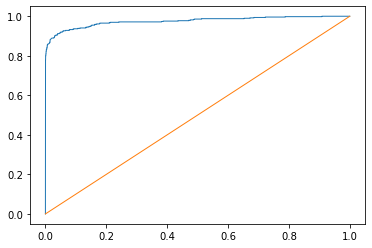

0.9748343854480698


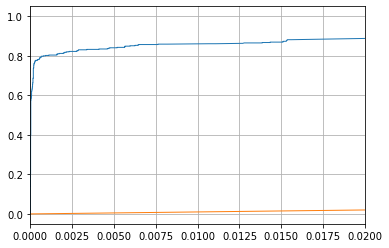

1%
fpr: 0.00818972073052309
tpr:  0.8588957055214724

420 84773 700 69
precision:  0.375
recall:  0.8588957055214724
F-measure: 0.5220633934120572
MCC: 0.564201103472003
0.5%
fpr: 0.0047500380237033915
tpr:  0.8404907975460123

411 85067 406 78
precision:  0.5030599755201959
recall:  0.8404907975460123
F-measure: 0.6294027565084227
MCC: 0.6478133350090203
0.1%
fpr: 0.0009125688814011442
tpr:  0.8016359918200409

392 85395 78 97
precision:  0.8340425531914893
recall:  0.8016359918200409
F-measure: 0.8175182481751825
MCC: 0.8166571496024192
Epoch 1/10
716/716 [==============================] - 13s 19ms/step - loss: 0.3497 - accuracy: 0.8669
Epoch 2/10
716/716 [==============================] - 12s 16ms/step - loss: 0.2575 - accuracy: 0.8949
Epoch 3/10
716/716 [==============================] - 11s 16ms/step - loss: 0.2379 - accuracy: 0.9038
Epoch 4/10
716/716 [==============================] - 12s 16ms/step - loss: 0.2263 - accuracy: 0.9106
Epoch 5/10
716/716 [===========================

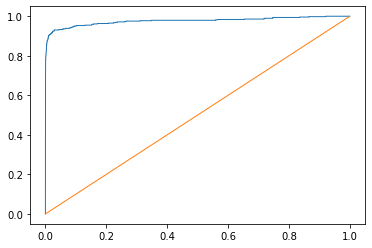

0.9761394532151975


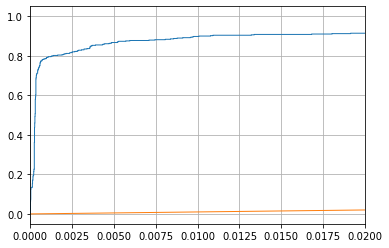

1%
fpr: 0.009839364477671312
tpr:  0.8977505112474438

439 84632 841 50
precision:  0.34296875
recall:  0.8977505112474438
F-measure: 0.4963256076879593
MCC: 0.5513633231249145
0.5%
fpr: 0.004867034034139436
tpr:  0.8670756646216768

424 85057 416 65
precision:  0.5047619047619047
recall:  0.8670756646216768
F-measure: 0.638073739653875
MCC: 0.6592053395192283
0.1%
fpr: 0.0009710668866191662
tpr:  0.7914110429447853

387 85390 83 102
precision:  0.823404255319149
recall:  0.7914110429447853
F-measure: 0.8070907194994787
MCC: 0.8061690707266012
Epoch 1/10
716/716 [==============================] - 14s 20ms/step - loss: 0.3391 - accuracy: 0.8736
Epoch 2/10
716/716 [==============================] - 11s 16ms/step - loss: 0.2605 - accuracy: 0.8943
Epoch 3/10
716/716 [==============================] - 12s 17ms/step - loss: 0.2485 - accuracy: 0.9004
Epoch 4/10
716/716 [==============================] - 11s 16ms/step - loss: 0.2405 - accuracy: 0.9084
Epoch 5/10
716/716 [======================

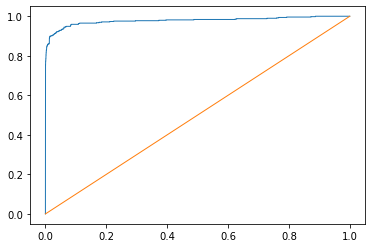

0.9779087367476598


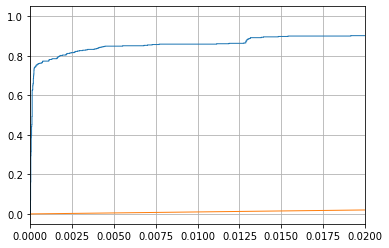

1%
fpr: 0.007698337486691704
tpr:  0.8588957055214724

420 84815 658 69
precision:  0.38961038961038963
recall:  0.8588957055214724
F-measure: 0.5360561582641991
MCC: 0.5752768220188358
0.5%
fpr: 0.004457547997613281
tpr:  0.8486707566462167

415 85092 381 74
precision:  0.5213567839195979
recall:  0.8486707566462167
F-measure: 0.6459143968871595
MCC: 0.6628746139776425
0.1%
fpr: 0.0007487744667906824
tpr:  0.7730061349693251

378 85409 64 111
precision:  0.8552036199095022
recall:  0.7730061349693251
F-measure: 0.8120300751879699
MCC: 0.8120559986473069
Epoch 1/10
716/716 [==============================] - 13s 18ms/step - loss: 0.2885 - accuracy: 0.8851
Epoch 2/10
716/716 [==============================] - 12s 16ms/step - loss: 0.2286 - accuracy: 0.9149
Epoch 3/10
716/716 [==============================] - 12s 16ms/step - loss: 0.2107 - accuracy: 0.9226
Epoch 4/10
716/716 [==============================] - 11s 16ms/step - loss: 0.2018 - accuracy: 0.9264
Epoch 5/10
716/716 [===========

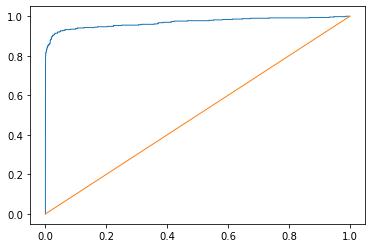

0.9689347838637474


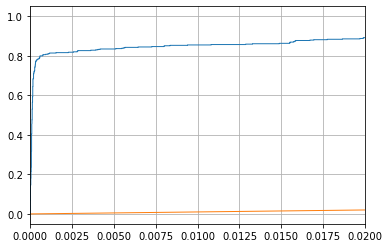

1%
fpr: 0.009394779638014343
tpr:  0.8548057259713702

418 84670 803 71
precision:  0.34234234234234234
recall:  0.8548057259713702
F-measure: 0.4888888888888888
MCC: 0.5373189355596065
0.5%
fpr: 0.004176757572566776
tpr:  0.8343558282208589

408 85116 357 81
precision:  0.5333333333333333
recall:  0.8343558282208589
F-measure: 0.6507177033492823
MCC: 0.664810415434746
0.1%
fpr: 0.0009242684824447487
tpr:  0.8077709611451943

395 85394 79 94
precision:  0.8333333333333334
recall:  0.8077709611451943
F-measure: 0.8203530633437176
MCC: 0.8194419197519789
Epoch 1/10
716/716 [==============================] - 13s 18ms/step - loss: 0.3605 - accuracy: 0.8728
Epoch 2/10
716/716 [==============================] - 13s 17ms/step - loss: 0.2588 - accuracy: 0.9000
Epoch 3/10
716/716 [==============================] - 11s 16ms/step - loss: 0.2359 - accuracy: 0.9156
Epoch 4/10
716/716 [==============================] - 13s 17ms/step - loss: 0.2297 - accuracy: 0.9192
Epoch 5/10
716/716 [=============

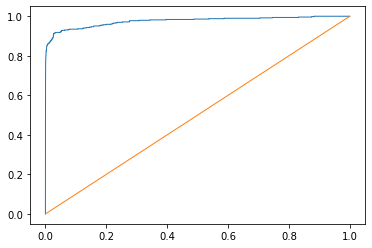

0.9753963132188481


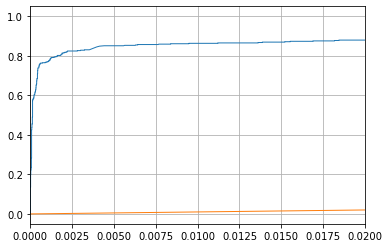

1%
fpr: 0.009991459291238168
tpr:  0.8629856850715747

422 84619 854 67
precision:  0.33072100313479624
recall:  0.8629856850715747
F-measure: 0.47818696883852696
MCC: 0.5304981176940448
0.5%
fpr: 0.004960630842488272
tpr:  0.8507157464212679

416 85049 424 73
precision:  0.49523809523809526
recall:  0.8507157464212679
F-measure: 0.6260346124905944
MCC: 0.6466257334205954
0.1%
fpr: 0.0009593672855755618
tpr:  0.7689161554192229

376 85391 82 113
precision:  0.8209606986899564
recall:  0.7689161554192229
F-measure: 0.7940865892291447
MCC: 0.7933772295684832
Epoch 1/10
716/716 [==============================] - 13s 18ms/step - loss: 0.3409 - accuracy: 0.8781
Epoch 2/10
716/716 [==============================] - 12s 16ms/step - loss: 0.2689 - accuracy: 0.89300s - los
Epoch 3/10
716/716 [==============================] - 11s 16ms/step - loss: 0.2502 - accuracy: 0.9055
Epoch 4/10
716/716 [==============================] - 12s 16ms/step - loss: 0.2329 - accuracy: 0.9183
Epoch 5/10
716/716 [=

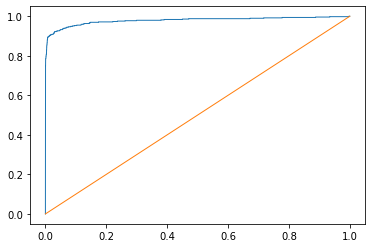

0.9787765887489984


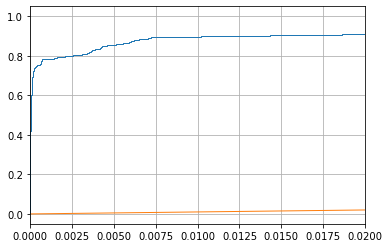

1%
fpr: 0.009991459291238168
tpr:  0.8957055214723927

438 84619 854 51
precision:  0.33900928792569657
recall:  0.8957055214723927
F-measure: 0.49185850645704654
MCC: 0.5474776651649659
0.5%
fpr: 0.004937231640401062
tpr:  0.8548057259713702

418 85051 422 71
precision:  0.4976190476190476
recall:  0.8548057259713702
F-measure: 0.6290443942814146
MCC: 0.6497706349452537
0.1%
fpr: 0.0009944660887063752
tpr:  0.7852760736196319

384 85388 85 105
precision:  0.8187633262260128
recall:  0.7852760736196319
F-measure: 0.801670146137787
MCC: 0.8007357778739972
Epoch 1/10
716/716 [==============================] - 14s 20ms/step - loss: 0.2784 - accuracy: 0.8973
Epoch 2/10
716/716 [==============================] - 11s 16ms/step - loss: 0.2149 - accuracy: 0.9265
Epoch 3/10
716/716 [==============================] - 12s 17ms/step - loss: 0.1729 - accuracy: 0.9471
Epoch 4/10
716/716 [==============================] - 11s 16ms/step - loss: 0.1494 - accuracy: 0.9566
Epoch 5/10
716/716 [===========

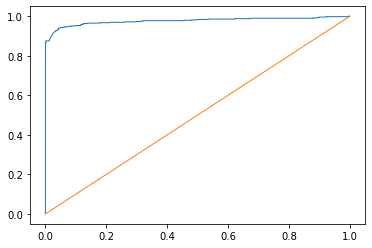

0.9765685342890544


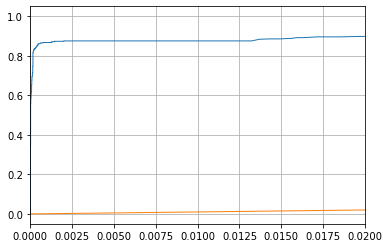

1%
fpr: 0.00996806008915096
tpr:  0.8752556237218814

428 84621 852 61
precision:  0.334375
recall:  0.8752556237218814
F-measure: 0.4838892029395138
MCC: 0.5373148296187658
0.5%
fpr: 0.004995729645619084
tpr:  0.8752556237218814

428 85046 427 61
precision:  0.5005847953216375
recall:  0.8752556237218814
F-measure: 0.636904761904762
MCC: 0.6595567577517001
0.1%
fpr: 0.0007604740678342868
tpr:  0.8670756646216768

424 85408 65 65
precision:  0.8670756646216768
recall:  0.8670756646216768
F-measure: 0.8670756646216768
MCC: 0.8663151905538427
Epoch 1/10
716/716 [==============================] - 14s 19ms/step - loss: 0.3710 - accuracy: 0.8786
Epoch 2/10
716/716 [==============================] - 11s 16ms/step - loss: 0.2880 - accuracy: 0.8959
Epoch 3/10
716/716 [==============================] - 12s 16ms/step - loss: 0.2645 - accuracy: 0.9062
Epoch 4/10
716/716 [==============================] - 12s 16ms/step - loss: 0.2439 - accuracy: 0.9164
Epoch 5/10
716/716 [=========================

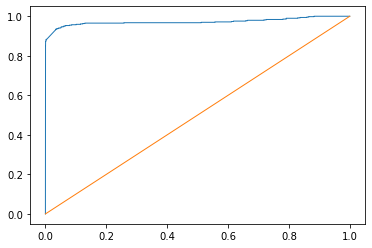

0.9722011497812832


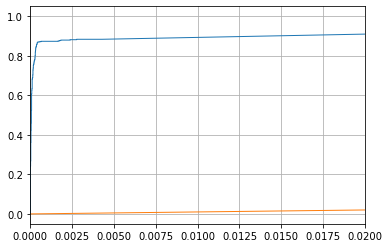

1%
fpr: 0.004282053981959215
tpr:  0.8834355828220859

432 85107 366 57
precision:  0.5413533834586466
recall:  0.8834355828220859
F-measure: 0.6713286713286712
MCC: 0.6894521902917095
0.5%
fpr: 0.004282053981959215
tpr:  0.8834355828220859

432 85107 366 57
precision:  0.5413533834586466
recall:  0.8834355828220859
F-measure: 0.6713286713286712
MCC: 0.6894521902917095
0.1%
fpr: 0.0006434780573982427
tpr:  0.8732106339468303

427 85418 55 62
precision:  0.8858921161825726
recall:  0.8732106339468303
F-measure: 0.8795056642636456
MCC: 0.878844398879736
Epoch 1/10
716/716 [==============================] - 13s 18ms/step - loss: 0.3180 - accuracy: 0.8992
Epoch 2/10
716/716 [==============================] - 13s 18ms/step - loss: 0.2451 - accuracy: 0.9211
Epoch 3/10
716/716 [==============================] - 11s 16ms/step - loss: 0.1994 - accuracy: 0.9421
Epoch 4/10
716/716 [==============================] - 13s 17ms/step - loss: 0.1693 - accuracy: 0.9541
Epoch 5/10
716/716 [==============

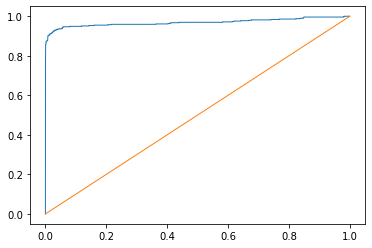

0.9687313806770967


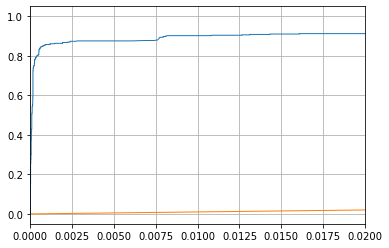

1%
fpr: 0.009979759690194564
tpr:  0.901840490797546

441 84620 853 48
precision:  0.3408037094281298
recall:  0.901840490797546
F-measure: 0.4946719012899607
MCC: 0.5508573604711873
0.5%
fpr: 0.004644741614310952
tpr:  0.8752556237218814

428 85076 397 61
precision:  0.5187878787878788
recall:  0.8752556237218814
F-measure: 0.6514459665144596
MCC: 0.6715940640263824
0.1%
fpr: 0.0009008692803575398
tpr:  0.8568507157464212

419 85396 77 70
precision:  0.844758064516129
recall:  0.8568507157464212
F-measure: 0.8507614213197968
MCC: 0.8499232195844496
Epoch 1/10
716/716 [==============================] - 13s 18ms/step - loss: 0.3279 - accuracy: 0.8884
Epoch 2/10
716/716 [==============================] - 12s 16ms/step - loss: 0.2437 - accuracy: 0.9153
Epoch 3/10
716/716 [==============================] - 11s 16ms/step - loss: 0.2019 - accuracy: 0.9374
Epoch 4/10
716/716 [==============================] - 12s 16ms/step - loss: 0.1640 - accuracy: 0.9569
Epoch 5/10
716/716 [================

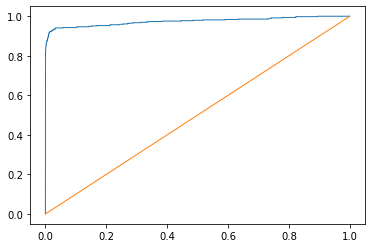

0.9742570256881847


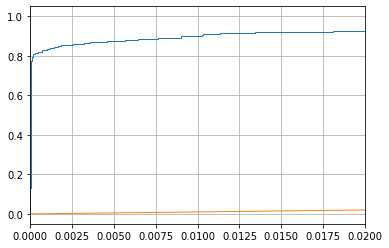

1%
fpr: 0.009804265674540498
tpr:  0.8997955010224948

440 84635 838 49
precision:  0.3442879499217527
recall:  0.8997955010224948
F-measure: 0.4980192416525183
MCC: 0.5530807261378243
0.5%
fpr: 0.004633042013267348
tpr:  0.8752556237218814

428 85077 396 61
precision:  0.5194174757281553
recall:  0.8752556237218814
F-measure: 0.6519421172886519
MCC: 0.6720065451351261
0.1%
fpr: 0.0008891696793139354
tpr:  0.8302658486707567

406 85397 76 83
precision:  0.8423236514522822
recall:  0.8302658486707567
F-measure: 0.8362512873326468
MCC: 0.8353432099448267
Epoch 1/10
716/716 [==============================] - 15s 21ms/step - loss: 0.3157 - accuracy: 0.8877
Epoch 2/10
716/716 [==============================] - 12s 16ms/step - loss: 0.2181 - accuracy: 0.9258
Epoch 3/10
716/716 [==============================] - 13s 18ms/step - loss: 0.1889 - accuracy: 0.9393
Epoch 4/10
716/716 [==============================] - 11s 16ms/step - loss: 0.1724 - accuracy: 0.9459
Epoch 5/10
716/716 [=============

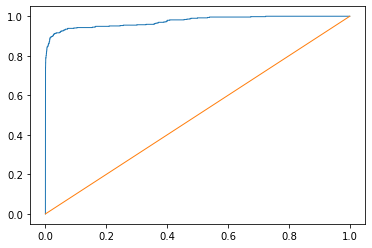

0.9745474581157273


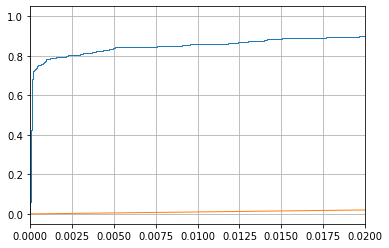

1%
fpr: 0.009523475249493991
tpr:  0.8588957055214724

420 84659 814 69
precision:  0.34035656401944897
recall:  0.8588957055214724
F-measure: 0.48752176436448064
MCC: 0.5370267311949118
0.5%
fpr: 0.0049489312414446665
tpr:  0.8404907975460123

411 85050 423 78
precision:  0.49280575539568344
recall:  0.8404907975460123
F-measure: 0.6213151927437642
MCC: 0.6410883409684721
0.1%
fpr: 0.0009710668866191662
tpr:  0.7811860940695297

382 85390 83 107
precision:  0.821505376344086
recall:  0.7811860940695297
F-measure: 0.80083857442348
MCC: 0.7999839972304461
Epoch 1/10
716/716 [==============================] - 14s 19ms/step - loss: 0.3222 - accuracy: 0.8856
Epoch 2/10
716/716 [==============================] - 11s 16ms/step - loss: 0.2391 - accuracy: 0.9122
Epoch 3/10
716/716 [==============================] - 12s 16ms/step - loss: 0.2156 - accuracy: 0.9230
Epoch 4/10
716/716 [==============================] - 12s 16ms/step - loss: 0.2009 - accuracy: 0.9294
Epoch 5/10
716/716 [===========

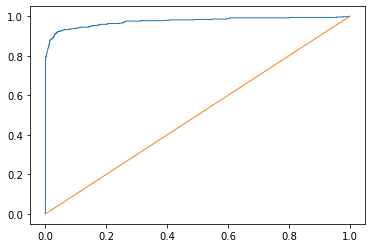

0.9742533650768153


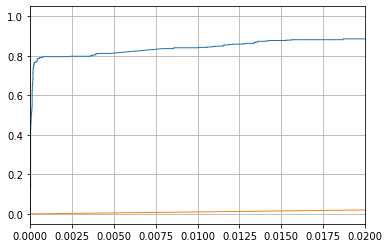

1%
fpr: 0.009979759690194564
tpr:  0.8404907975460123

411 84620 853 78
precision:  0.3251582278481013
recall:  0.8404907975460123
F-measure: 0.46891043924700515
MCC: 0.5189245261674643
0.5%
fpr: 0.004773437225790601
tpr:  0.8118609406952966

397 85065 408 92
precision:  0.493167701863354
recall:  0.8118609406952966
F-measure: 0.6136012364760433
MCC: 0.6302043686658627
0.1%
fpr: 0.0009359680834883531
tpr:  0.7955010224948875

389 85393 80 100
precision:  0.8294243070362474
recall:  0.7955010224948875
F-measure: 0.8121085594989561
MCC: 0.8112349707123774
Epoch 1/10
716/716 [==============================] - 14s 20ms/step - loss: 0.3211 - accuracy: 0.9013
Epoch 2/10
716/716 [==============================] - 12s 17ms/step - loss: 0.2124 - accuracy: 0.9267
Epoch 3/10
716/716 [==============================] - 12s 17ms/step - loss: 0.1865 - accuracy: 0.9351
Epoch 4/10
716/716 [==============================] - 13s 18ms/step - loss: 0.1569 - accuracy: 0.9484
Epoch 5/10
716/716 [============

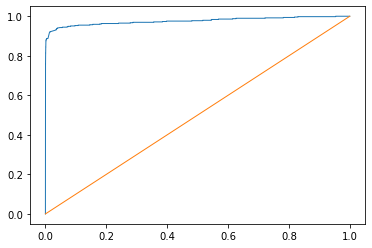

0.9760268475458483


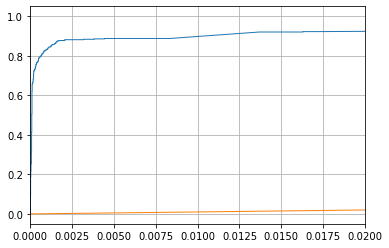

1%
fpr: 0.008341815544089947
tpr:  0.8875255623721882

434 84760 713 55
precision:  0.3783783783783784
recall:  0.8875255623721882
F-measure: 0.5305623471882641
MCC: 0.5762759720493602
0.5%
fpr: 0.004445848396569677
tpr:  0.8875255623721882

434 85093 380 55
precision:  0.5331695331695332
recall:  0.8875255623721882
F-measure: 0.6661550268610897
MCC: 0.6857556325090235
0.1%
fpr: 0.0009593672855755618
tpr:  0.8323108384458078

407 85391 82 82
precision:  0.8323108384458078
recall:  0.8323108384458078
F-measure: 0.8323108384458077
MCC: 0.8313514711602322
Epoch 1/10
716/716 [==============================] - 14s 19ms/step - loss: 0.3838 - accuracy: 0.8715
Epoch 2/10
716/716 [==============================] - 12s 16ms/step - loss: 0.2842 - accuracy: 0.8878
Epoch 3/10
716/716 [==============================] - 12s 16ms/step - loss: 0.2699 - accuracy: 0.8907
Epoch 4/10
716/716 [==============================] - 12s 17ms/step - loss: 0.2591 - accuracy: 0.8932
Epoch 5/10
716/716 [=============

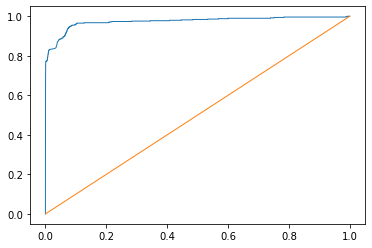

0.9737097642884488


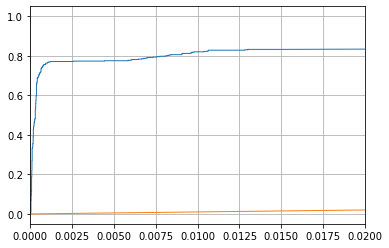

1%
fpr: 0.009792566073496893
tpr:  0.820040899795501

401 84636 837 88
precision:  0.32390953150242324
recall:  0.820040899795501
F-measure: 0.4643891140706427
MCC: 0.5114739291396478
0.5%
fpr: 0.004434148795526073
tpr:  0.7750511247443763

379 85094 379 110
precision:  0.5
recall:  0.7750511247443763
F-measure: 0.6078588612670409
MCC: 0.6199303240380137
0.1%
fpr: 0.0009359680834883531
tpr:  0.7627811860940695

373 85393 80 116
precision:  0.8233995584988962
recall:  0.7627811860940695
F-measure: 0.7919320594479831
MCC: 0.7913719165978176
Epoch 1/10
716/716 [==============================] - 15s 21ms/step - loss: 0.3377 - accuracy: 0.8871
Epoch 2/10
716/716 [==============================] - 12s 17ms/step - loss: 0.2455 - accuracy: 0.9169
Epoch 3/10
716/716 [==============================] - 13s 18ms/step - loss: 0.2149 - accuracy: 0.9285
Epoch 4/10
716/716 [==============================] - 12s 16ms/step - loss: 0.1884 - accuracy: 0.9391
Epoch 5/10
716/716 [===========================

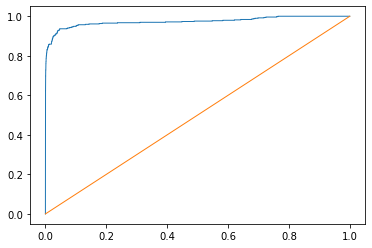

0.9734518586658526


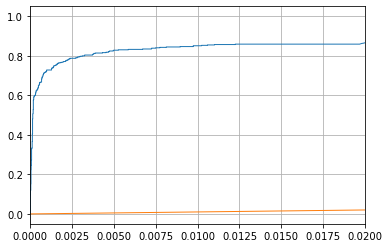

1%
fpr: 0.009745767669322477
tpr:  0.8507157464212679

416 84640 833 73
precision:  0.33306645316253003
recall:  0.8507157464212679
F-measure: 0.4787111622554661
MCC: 0.5285586025537456
0.5%
fpr: 0.00498403004457548
tpr:  0.8282208588957055

405 85047 426 84
precision:  0.48736462093862815
recall:  0.8282208588957055
F-measure: 0.6136363636363636
MCC: 0.632775003649313
0.1%
fpr: 0.0009827664876627708
tpr:  0.7280163599182005

356 85389 84 133
precision:  0.8090909090909091
recall:  0.7280163599182005
F-measure: 0.7664155005382133
MCC: 0.7662281780452538
Epoch 1/10
716/716 [==============================] - 14s 20ms/step - loss: 0.3447 - accuracy: 0.8915
Epoch 2/10
716/716 [==============================] - 12s 16ms/step - loss: 0.2309 - accuracy: 0.9223
Epoch 3/10
716/716 [==============================] - 12s 17ms/step - loss: 0.1870 - accuracy: 0.9408
Epoch 4/10
716/716 [==============================] - 12s 16ms/step - loss: 0.1618 - accuracy: 0.9510
Epoch 5/10
716/716 [============

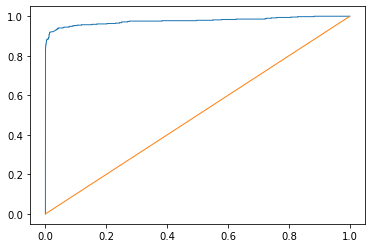

0.9765693357954653


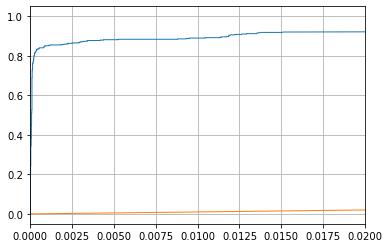

1%
fpr: 0.009979759690194564
tpr:  0.8895705521472392

435 84620 853 54
precision:  0.33773291925465837
recall:  0.8895705521472392
F-measure: 0.48958919527293193
MCC: 0.5445234759130203
0.5%
fpr: 0.004387350391351655
tpr:  0.8813905930470347

431 85098 375 58
precision:  0.5347394540942928
recall:  0.8813905930470347
F-measure: 0.6656370656370656
MCC: 0.6843762895877047
0.1%
fpr: 0.000877470078270331
tpr:  0.8507157464212679

416 85398 75 73
precision:  0.8472505091649695
recall:  0.8507157464212679
F-measure: 0.8489795918367348
MCC: 0.84811560133872
Epoch 1/10
716/716 [==============================] - 14s 20ms/step - loss: 0.3513 - accuracy: 0.8867
Epoch 2/10
716/716 [==============================] - 13s 18ms/step - loss: 0.2499 - accuracy: 0.9143
Epoch 3/10
716/716 [==============================] - 11s 16ms/step - loss: 0.2014 - accuracy: 0.9384
Epoch 4/10
716/716 [==============================] - 13s 18ms/step - loss: 0.1844 - accuracy: 0.9459
Epoch 5/10
716/716 [==============

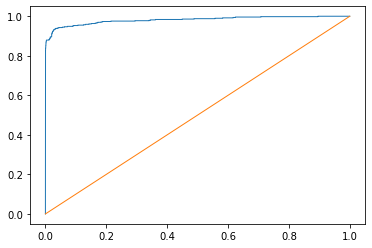

0.9812017437812732


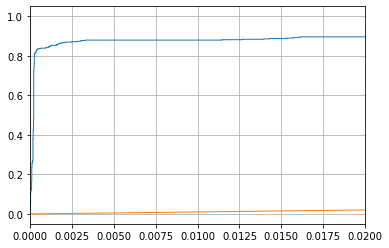

1%
fpr: 0.009874463280802125
tpr:  0.8793456032719836

430 84629 844 59
precision:  0.33751962323390894
recall:  0.8793456032719836
F-measure: 0.4878048780487805
MCC: 0.5411634068407022
0.5%
fpr: 0.0032758882922092358
tpr:  0.8793456032719836

430 85193 280 59
precision:  0.6056338028169014
recall:  0.8793456032719836
F-measure: 0.7172643869891576
MCC: 0.727991164137182
0.1%
fpr: 0.0009593672855755618
tpr:  0.8425357873210634

412 85391 82 77
precision:  0.8340080971659919
recall:  0.8425357873210634
F-measure: 0.8382502543234995
MCC: 0.8373310898305426
Epoch 1/10
716/716 [==============================] - 14s 19ms/step - loss: 0.3752 - accuracy: 0.8806.376
Epoch 2/10
716/716 [==============================] - 12s 16ms/step - loss: 0.3013 - accuracy: 0.8867
Epoch 3/10
716/716 [==============================] - 11s 16ms/step - loss: 0.2751 - accuracy: 0.8957
Epoch 4/10
716/716 [==============================] - 12s 17ms/step - loss: 0.2469 - accuracy: 0.9151
Epoch 5/10
716/716 [========

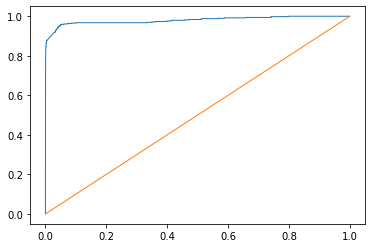

0.9796762497883486


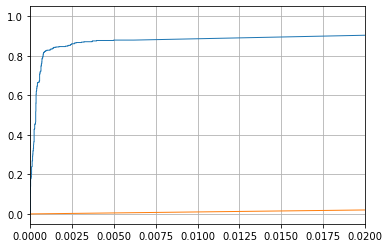

1%
fpr: 0.006189088952066734
tpr:  0.8793456032719836

430 84944 529 59
precision:  0.4483837330552659
recall:  0.8793456032719836
F-measure: 0.5939226519337016
MCC: 0.6252224607906559
0.5%
fpr: 0.00498403004457548
tpr:  0.8793456032719836

430 85047 426 59
precision:  0.5023364485981309
recall:  0.8793456032719836
F-measure: 0.6394052044609665
MCC: 0.662282064982435
0.1%
fpr: 0.0009944660887063752
tpr:  0.8282208588957055

405 85388 85 84
precision:  0.826530612244898
recall:  0.8282208588957055
F-measure: 0.8273748723186926
MCC: 0.826386687346672
Epoch 1/10
716/716 [==============================] - 15s 21ms/step - loss: 0.3865 - accuracy: 0.8936
Epoch 2/10
716/716 [==============================] - 12s 16ms/step - loss: 0.2694 - accuracy: 0.9224
Epoch 3/10
716/716 [==============================] - 12s 17ms/step - loss: 0.2339 - accuracy: 0.9337
Epoch 4/10
716/716 [==============================] - 12s 16ms/step - loss: 0.2024 - accuracy: 0.9441
Epoch 5/10
716/716 [=================

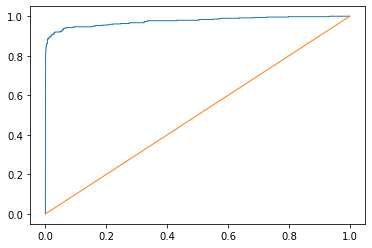

0.9754926853926797


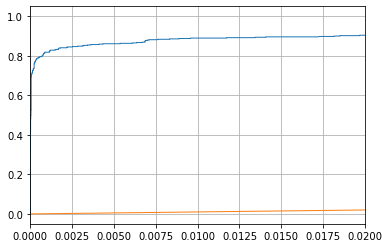

1%
fpr: 0.009979759690194564
tpr:  0.8895705521472392

435 84620 853 54
precision:  0.33773291925465837
recall:  0.8895705521472392
F-measure: 0.48958919527293193
MCC: 0.5445234759130203
0.5%
fpr: 0.0043522515882208415
tpr:  0.8609406952965235

421 85101 372 68
precision:  0.5308953341740227
recall:  0.8609406952965235
F-measure: 0.6567862714508581
MCC: 0.6738507973528749
0.1%
fpr: 0.000877470078270331
tpr:  0.8179959100204499

400 85398 75 89
precision:  0.8421052631578947
recall:  0.8179959100204499
F-measure: 0.8298755186721991
MCC: 0.8290048502995129


In [4]:
l2param=0.001

for cnn_n in [1, 2]:
  for lstm_n in [1, 2]:
    for cnn_filter in [8, 16, 32]:
      for lstm_unit in [64, 128, 256]:
        model = Sequential()
        for _ in range(cnn_n):
          model.add(TimeDistributed(
            Conv1D(cnn_filter, 4, padding = "valid",
                   kernel_regularizer=tf.keras.regularizers.l2(l2param))
            ))

          #model.add(TimeDistributed(BatchNormalization()))
          model.add(TimeDistributed(ReLU()))
          model.add(TimeDistributed(MaxPooling1D(2)))
          #model.add(TimeDistributed(Dropout(0.4)))

        model.add(TimeDistributed(Flatten()))
        for _ in range(lstm_n-1):
          model.add(LSTM(units=lstm_unit, return_sequences=True,
                         kernel_regularizer=tf.keras.regularizers.l2(l2param)
                      ))
        model.add(LSTM(units=lstm_unit,
                      kernel_regularizer=tf.keras.regularizers.l2(l2param)
                      ))
        model.add(Dense(2, activation='sigmoid',
                        kernel_regularizer=tf.keras.regularizers.l2(l2param)))

        model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0005), metrics=['accuracy'])

        model.fit(training_set, epochs=10, verbose=1)

        
        print("=================Setting================")
        print("cnn_n:", cnn_n)
        print("lstm_n:", lstm_n)
        print("cnn_filter:", cnn_filter)
        print("lstm_unit:", lstm_unit)
        
        from sklearn.metrics import roc_curve, auc
        import matplotlib.pyplot as plt


        result = model.predict(test_set)[:, 1]
        #plt.figure()
        #plt.plot(result[:100])
        #plt.show()
        new_label = test_y[:,1]
        #new_label = 1-label
        #new_label = label.astype(np.int)

        #print(result[1500:1600])
        #print(new_label[1500:1600])
        fpr, tpr, thesholds = roc_curve(new_label, result)
        print(thesholds)
        plt.figure()
        plt.plot(fpr, tpr, lw=1)

        mean_fpr = np.linspace(0, 1, 100)
        plt.plot(mean_fpr, mean_fpr, lw=1)
        plt.show()
        print(auc(fpr, tpr))

        plt.figure()
        plt.plot(fpr, tpr, lw=1)

        mean_fpr = np.linspace(0, 1, 100)
        plt.xlim([0, 0.02])
        plt.grid("on")
        plt.plot(mean_fpr, mean_fpr, lw=1)
        plt.show()

        print("1%")
        for i in range(len(fpr)):
          if fpr[i] > 0.01: #1%
            if (i > 0): i -= 1
            break;
        print("fpr:", fpr[i])
        print("tpr: ",tpr[i])
        print()
        predicted = result >= thesholds[i]
        TP = int(sum(np.logical_and(new_label==1,  predicted==1)))
        TN = int(sum(np.logical_and(new_label==0,  predicted==0)))
        FP = int(sum(np.logical_and(new_label==0,  predicted==1)))
        FN = int(sum(np.logical_and(new_label==1,  predicted==0)))

        print(TP,TN,FP,FN)

        Precision = TP/(TP+FP)
        Recall = TP/(TP+FN)

        print("precision: ", Precision)
        print("recall: ", Recall)
        print("F-measure:", (2*Precision*Recall)/(Precision+Recall))
        print("MCC:", (TP*TN-FP*FN)/np.sqrt((TP+FN)*(TP+FP)*(TN+FP)*(TN+FN)))

        print("0.5%")
        for i in range(len(fpr)):
          if fpr[i] > 0.005: #0.5%
            if (i > 0): i -= 1
            break;
        print("fpr:", fpr[i])
        print("tpr: ",tpr[i])
        print()
        predicted = result >= thesholds[i]
        TP = int(sum(np.logical_and(new_label==1,  predicted==1)))
        TN = int(sum(np.logical_and(new_label==0,  predicted==0)))
        FP = int(sum(np.logical_and(new_label==0,  predicted==1)))
        FN = int(sum(np.logical_and(new_label==1,  predicted==0)))

        print(TP,TN,FP,FN)

        Precision = TP/(TP+FP)
        Recall = TP/(TP+FN)

        print("precision: ", Precision)
        print("recall: ", Recall)
        print("F-measure:", (2*Precision*Recall)/(Precision+Recall))
        print("MCC:", (TP*TN-FP*FN)/np.sqrt((TP+FN)*(TP+FP)*(TN+FP)*(TN+FN)))

        print("0.1%")
        for i in range(len(fpr)):
          if fpr[i] > 0.001: #0.1%
            if (i > 0): i -= 1
            break;
        print("fpr:", fpr[i])
        print("tpr: ",tpr[i])
        print()
        predicted = result >= thesholds[i]
        TP = int(sum(np.logical_and(new_label==1,  predicted==1)))
        TN = int(sum(np.logical_and(new_label==0,  predicted==0)))
        FP = int(sum(np.logical_and(new_label==0,  predicted==1)))
        FN = int(sum(np.logical_and(new_label==1,  predicted==0)))

        print(TP,TN,FP,FN)

        Precision = TP/(TP+FP)
        Recall = TP/(TP+FN)

        print("precision: ", Precision)
        print("recall: ", Recall)
        print("F-measure:", (2*Precision*Recall)/(Precision+Recall))
        print("MCC:", (TP*TN-FP*FN)/np.sqrt((TP+FN)*(TP+FP)*(TN+FP)*(TN+FN)))

training time (sec):  388.24016547203064
training time per sample (sec):  5.812874821597202e-05
reference_time (sec):  121.20771527290344
reference_time per sample:  5.314076815654635e-05
[1.9995918e+00 9.9959177e-01 9.9957806e-01 ... 7.6782075e-05 7.6779586e-05
 6.9241505e-05]


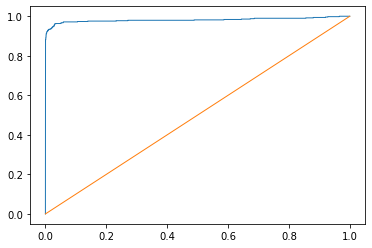

0.9814080447594895


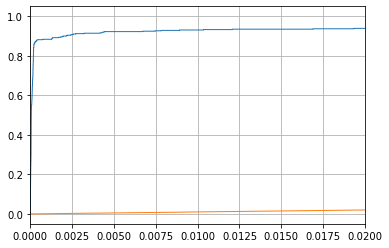

1%
fpr: 0.009999162424338633
tpr:  0.9304703476482618

455 2257589 22802 34
precision:  0.01956400223588597
recall:  0.9304703476482618
F-measure: 0.038322243746315175


TypeError: loop of ufunc does not support argument 0 of type int which has no callable sqrt method

In [3]:




l2param=0.001

model = Sequential()
model.add(TimeDistributed(
  Conv1D(16, 4, padding = "valid",
         kernel_regularizer=tf.keras.regularizers.l2(l2param))
  ))

#model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(ReLU()))
model.add(TimeDistributed(MaxPooling1D(2)))
#model.add(TimeDistributed(Dropout(0.4)))
#model.add(TimeDistributed(Conv1D(16, 3, padding = "valid")))
#model.add(TimeDistributed(BatchNormalization()))
#model.add(TimeDistributed(ReLU()))
#model.add(TimeDistributed(MaxPooling1D(2)))
#model.add(TimeDistributed(Dropout(0.4)))

model.add(TimeDistributed(Flatten()))

#model.add(LSTM(units=256, return_sequences=True, dropout=0.5))
model.add(LSTM(units=256,
              kernel_regularizer=tf.keras.regularizers.l2(l2param)
              ))
model.add(Dense(2, activation='sigmoid',
                kernel_regularizer=tf.keras.regularizers.l2(l2param)))

model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0005), metrics=['accuracy'])



start = time.time()
model.fit(training_set, epochs=10, verbose=0)
end = time.time()

print("training time (sec): ", end - start)
print("training time per sample (sec): ", (end-start)/(training_x.shape[0]*10))

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

start = time.time()
result = model.predict(test_set)[:, 1]
end = time.time()

print("reference_time (sec): ", end-start)
print("reference_time per sample: ", (end-start)/test_x.shape[0])

#plt.figure()
#plt.plot(result[:100])
#plt.show()
new_label = test_y[:,1]
#new_label = 1-label
#new_label = label.astype(np.int)

#print(result[1500:1600])
#print(new_label[1500:1600])
fpr, tpr, thesholds = roc_curve(new_label, result)
print(thesholds)
plt.figure()
plt.plot(fpr, tpr, lw=1)

mean_fpr = np.linspace(0, 1, 100)
plt.plot(mean_fpr, mean_fpr, lw=1)
plt.show()
print(auc(fpr, tpr))

plt.figure()
plt.plot(fpr, tpr, lw=1)

mean_fpr = np.linspace(0, 1, 100)
plt.xlim([0, 0.02])
plt.grid("on")
plt.plot(mean_fpr, mean_fpr, lw=1)
plt.show()

print("1%")
for i in range(len(fpr)):
  if fpr[i] > 0.01: #1%
    if (i > 0): i -= 1
    break;
print("fpr:", fpr[i])
print("tpr: ",tpr[i])
print()
predicted = result >= thesholds[i]
TP = int(sum(np.logical_and(new_label==1,  predicted==1)))
TN = int(sum(np.logical_and(new_label==0,  predicted==0)))
FP = int(sum(np.logical_and(new_label==0,  predicted==1)))
FN = int(sum(np.logical_and(new_label==1,  predicted==0)))

print(TP,TN,FP,FN)

Precision = TP/(TP+FP)
Recall = TP/(TP+FN)

print("precision: ", Precision)
print("recall: ", Recall)
print("F-measure:", (2*Precision*Recall)/(Precision+Recall))
print("MCC:", (TP*TN-FP*FN)/np.sqrt((TP+FN)*(TP+FP)*(TN+FP)*(TN+FN)))

print("0.5%")
for i in range(len(fpr)):
  if fpr[i] > 0.005: #0.5%
    if (i > 0): i -= 1
    break;
print("fpr:", fpr[i])
print("tpr: ",tpr[i])
print()
predicted = result >= thesholds[i]
TP = int(sum(np.logical_and(new_label==1,  predicted==1)))
TN = int(sum(np.logical_and(new_label==0,  predicted==0)))
FP = int(sum(np.logical_and(new_label==0,  predicted==1)))
FN = int(sum(np.logical_and(new_label==1,  predicted==0)))

print(TP,TN,FP,FN)

Precision = TP/(TP+FP)
Recall = TP/(TP+FN)

print("precision: ", Precision)
print("recall: ", Recall)
print("F-measure:", (2*Precision*Recall)/(Precision+Recall))
print("MCC:", (TP*TN-FP*FN)/np.sqrt((TP+FN)*(TP+FP)*(TN+FP)*(TN+FN)))

print("0.1%")
for i in range(len(fpr)):
  if fpr[i] > 0.001: #0.1%
    if (i > 0): i -= 1
    break;
print("fpr:", fpr[i])
print("tpr: ",tpr[i])
print()
predicted = result >= thesholds[i]
TP = int(sum(np.logical_and(new_label==1,  predicted==1)))
TN = int(sum(np.logical_and(new_label==0,  predicted==0)))
FP = int(sum(np.logical_and(new_label==0,  predicted==1)))
FN = int(sum(np.logical_and(new_label==1,  predicted==0)))

print(TP,TN,FP,FN)

Precision = TP/(TP+FP)
Recall = TP/(TP+FN)

print("precision: ", Precision)
print("recall: ", Recall)
print("F-measure:", (2*Precision*Recall)/(Precision+Recall))
print("MCC:", (TP*TN-FP*FN)/np.sqrt((TP+FN)*(TP+FP)*(TN+FP)*(TN+FN)))




In [3]:
print("reference_time (sec): ", end-start)
print("reference_time per sample: ", (end-start)/test_x.shape[0])


reference_time (sec):  4.332534313201904
reference_time per sample:  5.033616406266735e-05


In [3]:
import pickle
data_dictionary = {}
data_dictionary['result'] = result
data_dictionary['new_label'] = new_label

with open("CNN-LSTM_DICT.pck", "wb") as file:
  pickle.dump(data_dictionary, file)

크기 86134
비정상 489
[1.9992986e+00 9.9929857e-01 9.9864143e-01 ... 2.0953038e-04 2.0947962e-04
 3.1343097e-05]


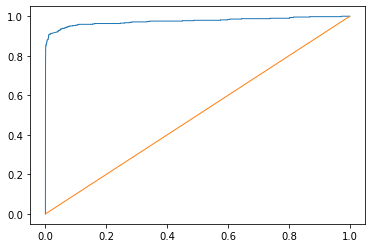

0.9753207377053781


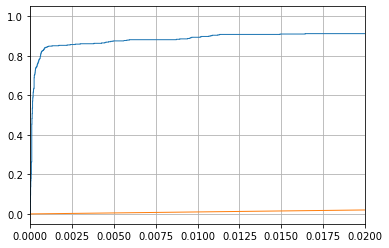

1%
fpr: 0.0098546324945998
tpr:  0.8936605316973415

437 84801 844 52
precision:  0.3411397345823575
recall:  0.8936605316973415
F-measure: 0.49378531073446325
MCC: 0.5485979328615184
0.5%
fpr: 0.004950668457002744
tpr:  0.8752556237218814

428 85221 424 61
precision:  0.5023474178403756
recall:  0.8752556237218814
F-measure: 0.6383296047725578
MCC: 0.6607366650009239
0.1%
fpr: 0.000992468912370833
tpr:  0.8445807770961146

413 85560 85 76
precision:  0.8293172690763052
recall:  0.8445807770961146
F-measure: 0.8368794326241135
MCC: 0.835974692531603


In [1]:
#load_data
import pickle

with open("CNN-LSTM_DICT.pck", "rb") as file:
  data_dictionary = pickle.load(file)
result = data_dictionary['result']
new_label = data_dictionary['new_label']

import itertools
import pandas as pd
import glob
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import scale
from sklearn import mixture
from sklearn.naive_bayes import GaussianNB
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt



print('크기', len(new_label))
print('비정상', sum(new_label))
fpr, tpr, thesholds = roc_curve(new_label, result)
print(thesholds)
plt.figure()
plt.plot(fpr, tpr, lw=1)
mean_fpr = np.linspace(0, 1, 100)
plt.plot(mean_fpr, mean_fpr, lw=1)
plt.show()
print(auc(fpr, tpr))

plt.figure()
plt.plot(fpr, tpr, lw=1)

mean_fpr = np.linspace(0, 1, 100)
plt.xlim([0, 0.02])
plt.grid("on")
plt.plot(mean_fpr, mean_fpr, lw=1)
plt.show()

print("1%")
for i in range(len(fpr)):
  if fpr[i] > 0.01: #1%
    if (i > 0): i -= 1
    break;
print("fpr:", fpr[i])
print("tpr: ",tpr[i])
print()
predicted = result >= thesholds[i]
TP = int(sum(np.logical_and(new_label==1,  predicted==1)))
TN = int(sum(np.logical_and(new_label==0,  predicted==0)))
FP = int(sum(np.logical_and(new_label==0,  predicted==1)))
FN = int(sum(np.logical_and(new_label==1,  predicted==0)))

print(TP,TN,FP,FN)

Precision = TP/(TP+FP)
Recall = TP/(TP+FN)

print("precision: ", Precision)
print("recall: ", Recall)
print("F-measure:", (2*Precision*Recall)/(Precision+Recall))
print("MCC:", (TP*TN-FP*FN)/np.sqrt((TP+FN)*(TP+FP)*(TN+FP)*(TN+FN)))

print("0.5%")
for i in range(len(fpr)):
  if fpr[i] > 0.005: #0.5%
    if (i > 0): i -= 1
    break;
print("fpr:", fpr[i])
print("tpr: ",tpr[i])
print()
predicted = result >= thesholds[i]
TP = int(sum(np.logical_and(new_label==1,  predicted==1)))
TN = int(sum(np.logical_and(new_label==0,  predicted==0)))
FP = int(sum(np.logical_and(new_label==0,  predicted==1)))
FN = int(sum(np.logical_and(new_label==1,  predicted==0)))

print(TP,TN,FP,FN)

Precision = TP/(TP+FP)
Recall = TP/(TP+FN)

print("precision: ", Precision)
print("recall: ", Recall)
print("F-measure:", (2*Precision*Recall)/(Precision+Recall))
print("MCC:", (TP*TN-FP*FN)/np.sqrt((TP+FN)*(TP+FP)*(TN+FP)*(TN+FN)))

print("0.1%")
for i in range(len(fpr)):
  if fpr[i] > 0.001: #0.1%
    if (i > 0): i -= 1
    break;
print("fpr:", fpr[i])
print("tpr: ",tpr[i])
print()
predicted = result >= thesholds[i]
TP = int(sum(np.logical_and(new_label==1,  predicted==1)))
TN = int(sum(np.logical_and(new_label==0,  predicted==0)))
FP = int(sum(np.logical_and(new_label==0,  predicted==1)))
FN = int(sum(np.logical_and(new_label==1,  predicted==0)))

print(TP,TN,FP,FN)

Precision = TP/(TP+FP)
Recall = TP/(TP+FN)

print("precision: ", Precision)
print("recall: ", Recall)
print("F-measure:", (2*Precision*Recall)/(Precision+Recall))
print("MCC:", (TP*TN-FP*FN)/np.sqrt((TP+FN)*(TP+FP)*(TN+FP)*(TN+FN)))

p_plus:  0.00034236600816637446
p_minus:  0.9996576339918336
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500


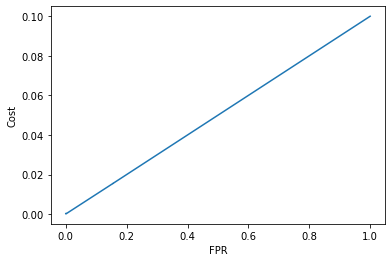

In [14]:
#총 데이터 중 정상 데이터 비율
normal_n = 2855614
#총 데이터중 비정상 데이터 비율
abnormal_n = 978

p_plus = abnormal_n/(normal_n+abnormal_n)
p_minus = normal_n/(normal_n+abnormal_n)

print("p_plus: ", p_plus)
print("p_minus: ", p_minus)
w_FNR = 0.9
w_FPR = 0.1

cost = []
for i in range(len(fpr)):
  if i % 100 == 0:
    print(i)
  predicted = result >= thesholds[i]
  TP = np.sum(np.logical_and(new_label==1,  predicted==1))
  TN = np.sum(np.logical_and(new_label==0,  predicted==0))
  FP = np.sum(np.logical_and(new_label==0,  predicted==1))
  FN = np.sum(np.logical_and(new_label==1,  predicted==0))
  FNR = FN/(FN+TP) #비정상 데이터중 미알람 비율
  FPR = FP/(FP+TN) #정상 데이터중 비정상 알람 비율
  
  cost.append(w_FNR*FNR*p_plus + w_FPR*FPR*p_minus)


plt.plot(fpr, cost)
plt.xlabel("FPR")
plt.ylabel("Cost")
plt.show()

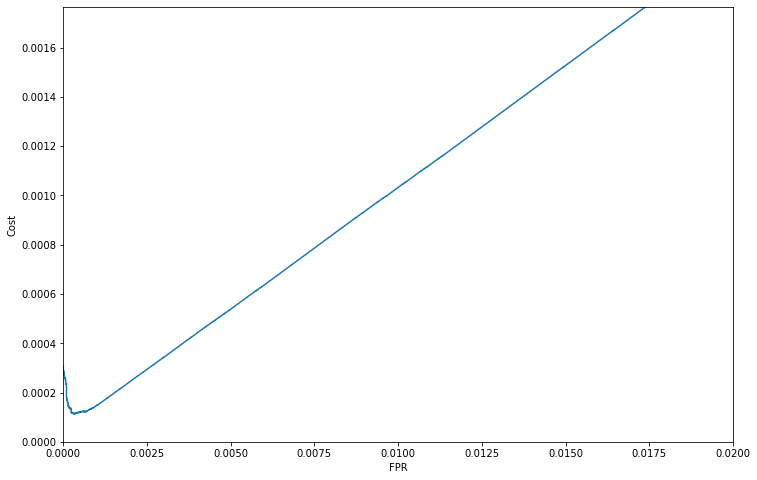

FPR at minimum cost: 0.0003152548309883823
0.00011343048320999492


In [15]:
plt.figure(figsize=[12, 8])
plt.plot(fpr, cost)
plt.xlabel("FPR")
plt.ylabel("Cost")
plt.xlim([0, 0.02])
plt.ylim([0, cost[400]])
plt.show()

print("FPR at minimum cost:", fpr[np.argmin(cost)])
print(np.amin(cost))

(978, 1)
(570097, 5, 24, 2)
(978, 5, 24, 2)
(667897, 5, 24, 2)
(667897, 2)
(2280880, 5, 24, 2)
(2280880, 2)
training time (sec):  370.67863845825195
training time per sample (sec):  5.549937167830548e-05
reference_time (sec):  116.43184185028076
reference_time per sample:  5.104689499240677e-05
[1.984924   0.98492396 0.9830625  ... 0.01455096 0.01455004 0.0115558 ]


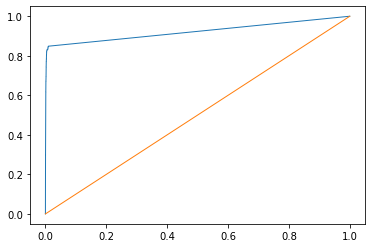

0.9228462582232573


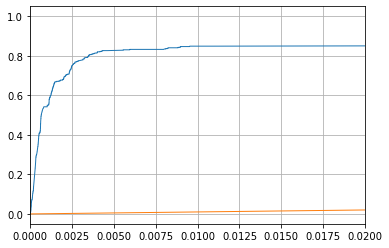

크기 2280880
비정상 489
[1.984924   0.98492396 0.9830625  ... 0.01455096 0.01455004 0.0115558 ]


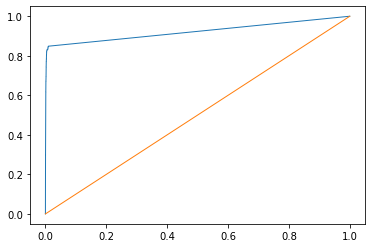

0.9228462582232573


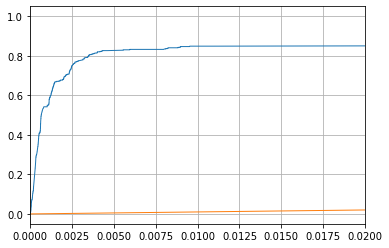

1%
fpr: 0.009993461647585874
tpr:  0.8486707566462167

415 2257602 22789 74
precision:  0.017884847440096534
recall:  0.8486707566462167
F-measure: 0.035031439843772674
MCC: 0.12236073946266036
0.5%
fpr: 0.004611489871693056
tpr:  0.8261758691206544

404 2269875 10516 85
precision:  0.036996336996337
recall:  0.8261758691206544
F-measure: 0.07082127323970609
MCC: 0.174253101904966
0.1%
fpr: 0.0008125799479124414
tpr:  0.5419222903885481

265 2278538 1853 224
precision:  0.1251180358829084
recall:  0.5419222903885481
F-measure: 0.20329878041601301
MCC: 0.2600950704054472


In [1]:

import os
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, BatchNormalization, ReLU, LSTM
from tensorflow.keras.layers import TimeDistributed
from tensorflow import keras
from tensorflow.keras import layers

import time
import itertools
import pandas as pd
import glob
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt
import gc


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    print(e)

total_df = pd.read_csv("to_mrmr.csv")

window_n = 5
stride = 12
window_size = 24
normal_scores = []
feature = [
           'rec_week',
           'rec_week2', ]






total_data = total_df.dropna().loc[:, ['label'] + feature].to_numpy()

del total_df
gc.collect()


where_abnormal = np.argwhere(total_data[:,0]==1)


#assert(False)




normal_data = []

for i in range(0,total_data.shape[0]-(window_size + (window_n-1)*stride )):
  ws = []
  for w_n in range(window_n):
    ws.append(total_data[(w_n*stride)+ i:(w_n*stride) + i +window_size])
  ws = np.array(ws)
  if np.all(ws[:,:,0] == 0):
    normal_data.append(ws[:, :, 1:])
  #if i == 1000:
  #  break;

normal_data = np.array(normal_data).astype(np.float32)

#print(normal_data.shape)
    
#assert(False)
#good_score.append(kl_divergence(w_p, normal_q))
abnormal_data = []

print(where_abnormal.shape)
for ab in where_abnormal:
  i = ab[0] + 1 - window_size - stride * (window_n-1)
  if (i < 0):
    continue
  ws = []
  for w_n in range(window_n):
    ws.append(total_data[(w_n*stride)+ i:(w_n*stride) + i +window_size, 1:])
  ws = np.array(ws)
  abnormal_data.append(ws)

abnormal_data = np.array(abnormal_data).astype(np.float32)

del total_data
gc.collect()

random_idx = np.arange(normal_data.shape[0])
np.random.shuffle(random_idx)
normal_data = normal_data[random_idx]

random_idx = np.arange(abnormal_data.shape[0])
np.random.shuffle(random_idx)
abnormal_data = abnormal_data[random_idx]

del random_idx

cut = normal_data.shape[0]//5

training_x = normal_data[:cut]
training_y = [[1, 0] for _ in range(cut)]
duplicate_weight = 200

print(training_x.shape)
print(abnormal_data.shape)

for _ in range(duplicate_weight):
  training_x = np.concatenate([training_x, abnormal_data[:abnormal_data.shape[0]//2]], axis = 0)
training_y = training_y + [[0, 1] for _ in range(training_x.shape[0]-len(training_y))]

training_y = np.array(training_y)


test_x = normal_data[cut:]
test_y = [[1, 0] for _ in range(normal_data.shape[0]-cut)]


test_x = np.concatenate([test_x, abnormal_data[abnormal_data.shape[0]//2:]], axis = 0)
test_y = test_y + [[0, 1] for _ in range(test_x.shape[0]-len(test_y))]

test_y = np.array(test_y)

print(training_x.shape)
print(training_y.shape)
print(test_x.shape)
print(test_y.shape)

del normal_data, abnormal_data
gc.collect()


def get_data():
    global training_x, training_y
    random_idx = np.arange(training_x.shape[0])
    np.random.shuffle(random_idx)
    training_x = training_x[random_idx]
    training_y = training_y[random_idx]
    for i in range(training_x.shape[0]):
      x = training_x[i].astype(np.float32)
      y = training_y[i].astype(np.int8)
      yield (x, y)

training_set = tf.data.Dataset.from_generator(get_data, (tf.float32, np.int8), ((window_n, window_size, len(feature)), (2)))

training_set = training_set.batch(256)



def get_test_data():
    global test_x, test_y
    for i in range(test_x.shape[0]):
      x = test_x[i].astype(np.float32)
      y = test_y[i].astype(np.int8)
      yield (x, y)

test_set = tf.data.Dataset.from_generator(get_test_data, (tf.float32, np.int8), ((window_n, window_size, len(feature)), (2)))

test_set = test_set.batch(256)





l2param=0.001

model = Sequential()
model.add(TimeDistributed(
  Conv1D(16, 4, padding = "valid",
         kernel_regularizer=tf.keras.regularizers.l2(l2param))
  ))

#model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(ReLU()))
model.add(TimeDistributed(MaxPooling1D(2)))
#model.add(TimeDistributed(Dropout(0.4)))
#model.add(TimeDistributed(Conv1D(16, 3, padding = "valid")))
#model.add(TimeDistributed(BatchNormalization()))
#model.add(TimeDistributed(ReLU()))
#model.add(TimeDistributed(MaxPooling1D(2)))
#model.add(TimeDistributed(Dropout(0.4)))

model.add(TimeDistributed(Flatten()))

#model.add(LSTM(units=256, return_sequences=True, dropout=0.5))
model.add(LSTM(units=256,
              kernel_regularizer=tf.keras.regularizers.l2(l2param)
              ))
model.add(Dense(2, activation='sigmoid',
                kernel_regularizer=tf.keras.regularizers.l2(l2param)))

model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0005), metrics=['accuracy'])



start = time.time()
model.fit(training_set, epochs=10, verbose=0)
end = time.time()

print("training time (sec): ", end - start)
print("training time per sample (sec): ", (end-start)/(training_x.shape[0]*10))

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

start = time.time()
result = model.predict(test_set)[:, 1]
end = time.time()

print("reference_time (sec): ", end-start)
print("reference_time per sample: ", (end-start)/test_x.shape[0])

#plt.figure()
#plt.plot(result[:100])
#plt.show()
new_label = test_y[:,1]
#new_label = 1-label
#new_label = label.astype(np.int)

#print(result[1500:1600])
#print(new_label[1500:1600])
fpr, tpr, thesholds = roc_curve(new_label, result)
print(thesholds)
plt.figure()
plt.plot(fpr, tpr, lw=1)

mean_fpr = np.linspace(0, 1, 100)
plt.plot(mean_fpr, mean_fpr, lw=1)
plt.show()
print(auc(fpr, tpr))

plt.figure()
plt.plot(fpr, tpr, lw=1)

mean_fpr = np.linspace(0, 1, 100)
plt.xlim([0, 0.02])
plt.grid("on")
plt.plot(mean_fpr, mean_fpr, lw=1)
plt.show()







import itertools
import pandas as pd
import glob
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import scale
from sklearn import mixture
from sklearn.naive_bayes import GaussianNB
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt



print('크기', len(new_label))
print('비정상', sum(new_label))
fpr, tpr, thesholds = roc_curve(new_label, result)
print(thesholds)
plt.figure()
plt.plot(fpr, tpr, lw=1)
mean_fpr = np.linspace(0, 1, 100)
plt.plot(mean_fpr, mean_fpr, lw=1)
plt.show()
print(auc(fpr, tpr))

plt.figure()
plt.plot(fpr, tpr, lw=1)

mean_fpr = np.linspace(0, 1, 100)
plt.xlim([0, 0.02])
plt.grid("on")
plt.plot(mean_fpr, mean_fpr, lw=1)
plt.show()

print("1%")
for i in range(len(fpr)):
  if fpr[i] > 0.01: #1%
    if (i > 0): i -= 1
    break;
print("fpr:", fpr[i])
print("tpr: ",tpr[i])
print()
predicted = result >= thesholds[i]
TP = int(sum(np.logical_and(new_label==1,  predicted==1)))
TN = int(sum(np.logical_and(new_label==0,  predicted==0)))
FP = int(sum(np.logical_and(new_label==0,  predicted==1)))
FN = int(sum(np.logical_and(new_label==1,  predicted==0)))

print(TP,TN,FP,FN)

Precision = TP/(TP+FP)
Recall = TP/(TP+FN)

print("precision: ", Precision)
print("recall: ", Recall)
print("F-measure:", (2*Precision*Recall)/(Precision+Recall+1e-7))
print("MCC:", (TP*TN-FP*FN)/(np.sqrt((TP+FN)*(TP+FP)*(TN+FP)*(TN+FN)*1.0))+1e-7)

print("0.5%")
for i in range(len(fpr)):
  if fpr[i] > 0.005: #0.5%
    if (i > 0): i -= 1
    break;
print("fpr:", fpr[i])
print("tpr: ",tpr[i])
print()
predicted = result >= thesholds[i]
TP = int(sum(np.logical_and(new_label==1,  predicted==1)))
TN = int(sum(np.logical_and(new_label==0,  predicted==0)))
FP = int(sum(np.logical_and(new_label==0,  predicted==1)))
FN = int(sum(np.logical_and(new_label==1,  predicted==0)))

print(TP,TN,FP,FN)

Precision = TP/(TP+FP)
Recall = TP/(TP+FN)

print("precision: ", Precision)
print("recall: ", Recall)
print("F-measure:", (2*Precision*Recall)/(Precision+Recall+1e-7))
print("MCC:", (TP*TN-FP*FN)/(np.sqrt((TP+FN)*(TP+FP)*(TN+FP)*(TN+FN)*1.0))+1e-7)

print("0.1%")
for i in range(len(fpr)):
  if fpr[i] > 0.001: #0.1%
    if (i > 0): i -= 1
    break;
print("fpr:", fpr[i])
print("tpr: ",tpr[i])
print()
predicted = result >= thesholds[i]
TP = int(sum(np.logical_and(new_label==1,  predicted==1)))
TN = int(sum(np.logical_and(new_label==0,  predicted==0)))
FP = int(sum(np.logical_and(new_label==0,  predicted==1)))
FN = int(sum(np.logical_and(new_label==1,  predicted==0)))

print(TP,TN,FP,FN)

Precision = TP/(TP+FP)
Recall = TP/(TP+FN)

print("precision: ", Precision)
print("recall: ", Recall)
print("F-measure:", (2*Precision*Recall)/(Precision+Recall+1e-7))
print("MCC:", (TP*TN-FP*FN)/(np.sqrt((TP+FN)*(TP+FP)*(TN+FP)*(TN+FN)*1.0))+1e-7)

p_plus:  0.00034236600816637446
p_minus:  0.9996576339918336
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900


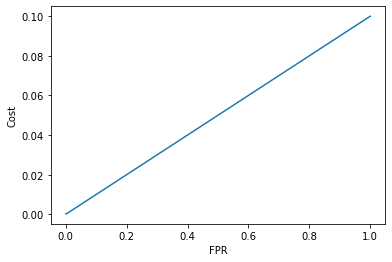

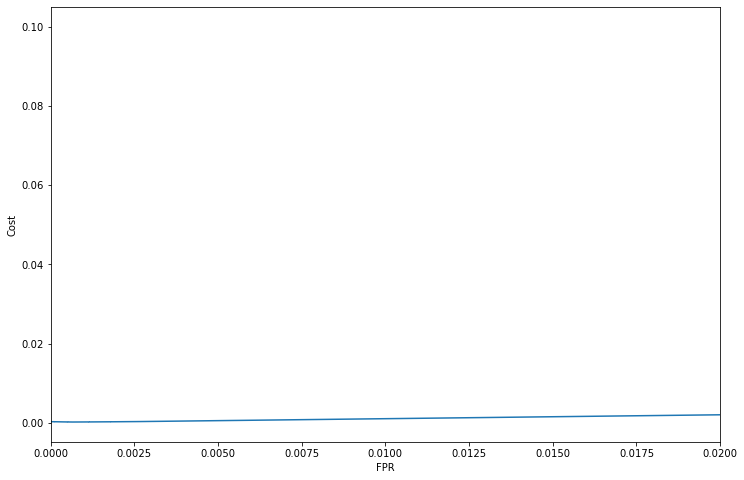

FPR at minimum cost: 0.000674445741980213
0.00021865064044984667
249 2278853 1538 240
precision:  0.13933967543368775
recall:  0.50920245398773
F-measure: 0.21880488717592358
MCC: 0.2660913945796711


In [2]:
#총 데이터 중 정상 데이터 비율
normal_n = 2855614
#총 데이터중 비정상 데이터 비율
abnormal_n = 978

p_plus = abnormal_n/(normal_n+abnormal_n)
p_minus = normal_n/(normal_n+abnormal_n)

print("p_plus: ", p_plus)
print("p_minus: ", p_minus)
w_FNR = 0.9
w_FPR = 0.1

cost = []
for i in range(len(fpr)):
  if i % 100 == 0:
    print(i)
  predicted = result >= thesholds[i]
  TP = np.sum(np.logical_and(new_label==1,  predicted==1))
  TN = np.sum(np.logical_and(new_label==0,  predicted==0))
  FP = np.sum(np.logical_and(new_label==0,  predicted==1))
  FN = np.sum(np.logical_and(new_label==1,  predicted==0))
  FNR = FN/(FN+TP) #비정상 데이터중 미알람 비율
  FPR = FP/(FP+TN) #정상 데이터중 비정상 알람 비율
  
  cost.append(w_FNR*FNR*p_plus + w_FPR*FPR*p_minus)


plt.plot(fpr, cost)
plt.xlabel("FPR")
plt.ylabel("Cost")
plt.show()

plt.figure(figsize=[12, 8])
plt.plot(fpr, cost)
plt.xlabel("FPR")
plt.ylabel("Cost")
plt.xlim([0, 0.02])
#plt.ylim([0, cost[400]])
plt.show()

print("FPR at minimum cost:", fpr[np.argmin(cost)])
print(np.amin(cost))

i = np.argmin(cost)
predicted = result >= thesholds[i]
TP = int(sum(np.logical_and(new_label==1,  predicted==1)))
TN = int(sum(np.logical_and(new_label==0,  predicted==0)))
FP = int(sum(np.logical_and(new_label==0,  predicted==1)))
FN = int(sum(np.logical_and(new_label==1,  predicted==0)))

print(TP,TN,FP,FN)

Precision = TP/(TP+FP)
Recall = TP/(TP+FN)


print("precision: ", Precision)
print("recall: ", Recall)
print("F-measure:", (2*Precision*Recall)/(Precision+Recall+1e-7))
print("MCC:", (TP*TN-FP*FN)/(np.sqrt((TP+FN)*(TP+FP)*(TN+FP)*(TN+FN)*1.0))+1e-7)

(978, 1)
(570097, 5, 24, 1)
(978, 5, 24, 1)
(667897, 5, 24, 1)
(667897, 2)
(2280880, 5, 24, 1)
(2280880, 2)
training time (sec):  367.3631172180176
training time per sample (sec):  5.500295962072259e-05
reference_time (sec):  120.87220644950867
reference_time per sample:  5.299367193780851e-05
[1.9918737  0.9918738  0.99144554 ... 0.00353729 0.00353653 0.00353498]


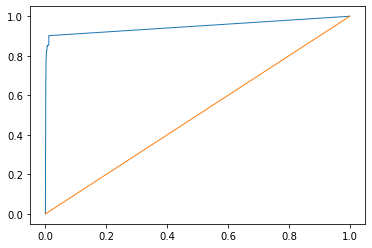

0.9492072848422718


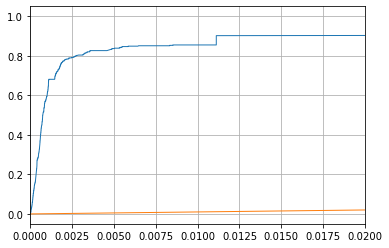

크기 2280880
비정상 489
[1.9918737  0.9918738  0.99144554 ... 0.00353729 0.00353653 0.00353498]


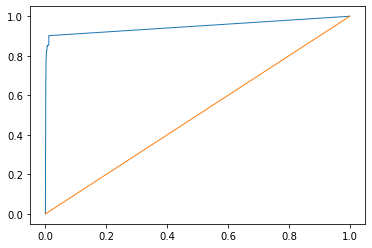

0.9492072848422718


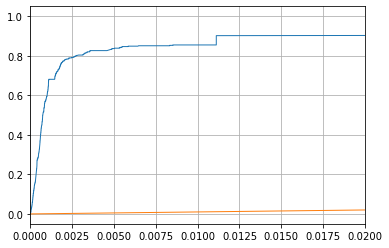

1%
fpr: 0.009999600945627306
tpr:  0.8548057259713702

418 2257588 22803 71
precision:  0.018000947418285174
recall:  0.8548057259713702
F-measure: 0.03525938018629518
MCC: 0.1232102568285571
0.5%
fpr: 0.004998265648303296
tpr:  0.83640081799591

409 2268993 11398 80
precision:  0.034640467519268234
recall:  0.83640081799591
F-measure: 0.06652569177695365
MCC: 0.16961985300420498
0.1%
fpr: 0.000998951495598781
tpr:  0.5950920245398773

291 2278113 2278 198
precision:  0.11327364733359284
recall:  0.5950920245398773
F-measure: 0.19032044402846854
MCC: 0.259313537173629
p_plus:  0.00034236600816637446
p_minus:  0.9996576339918336
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700


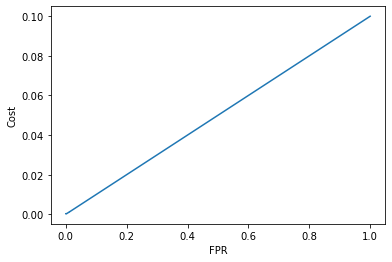

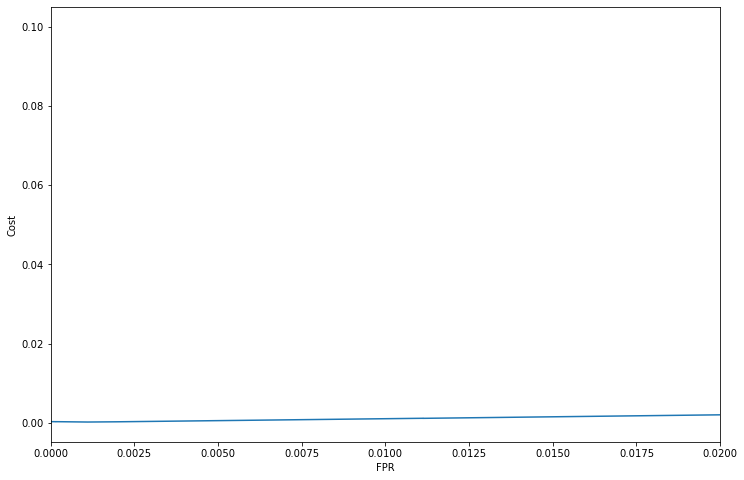

FPR at minimum cost: 0.0011094588603445636
0.00020920685397228517
333 2277861 2530 156
precision:  0.11631156129933636
recall:  0.6809815950920245
F-measure: 0.19868732591508748
MCC: 0.2811236166053268


In [1]:

import os
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, BatchNormalization, ReLU, LSTM
from tensorflow.keras.layers import TimeDistributed
from tensorflow import keras
from tensorflow.keras import layers

import time
import itertools
import pandas as pd
import glob
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt
import gc


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    print(e)

total_df = pd.read_csv("to_mrmr.csv")

window_n = 5
stride = 12
window_size = 24
normal_scores = []
feature = [
           'rec_week2', ]






total_data = total_df.dropna().loc[:, ['label'] + feature].to_numpy()

del total_df
gc.collect()


where_abnormal = np.argwhere(total_data[:,0]==1)


#assert(False)




normal_data = []

for i in range(0,total_data.shape[0]-(window_size + (window_n-1)*stride )):
  ws = []
  for w_n in range(window_n):
    ws.append(total_data[(w_n*stride)+ i:(w_n*stride) + i +window_size])
  ws = np.array(ws)
  if np.all(ws[:,:,0] == 0):
    normal_data.append(ws[:, :, 1:])
  #if i == 1000:
  #  break;

normal_data = np.array(normal_data).astype(np.float32)

#print(normal_data.shape)
    
#assert(False)
#good_score.append(kl_divergence(w_p, normal_q))
abnormal_data = []

print(where_abnormal.shape)
for ab in where_abnormal:
  i = ab[0] + 1 - window_size - stride * (window_n-1)
  if (i < 0):
    continue
  ws = []
  for w_n in range(window_n):
    ws.append(total_data[(w_n*stride)+ i:(w_n*stride) + i +window_size, 1:])
  ws = np.array(ws)
  abnormal_data.append(ws)

abnormal_data = np.array(abnormal_data).astype(np.float32)

del total_data
gc.collect()

random_idx = np.arange(normal_data.shape[0])
np.random.shuffle(random_idx)
normal_data = normal_data[random_idx]

random_idx = np.arange(abnormal_data.shape[0])
np.random.shuffle(random_idx)
abnormal_data = abnormal_data[random_idx]

del random_idx

cut = normal_data.shape[0]//5

training_x = normal_data[:cut]
training_y = [[1, 0] for _ in range(cut)]
duplicate_weight = 200

print(training_x.shape)
print(abnormal_data.shape)

for _ in range(duplicate_weight):
  training_x = np.concatenate([training_x, abnormal_data[:abnormal_data.shape[0]//2]], axis = 0)
training_y = training_y + [[0, 1] for _ in range(training_x.shape[0]-len(training_y))]

training_y = np.array(training_y)


test_x = normal_data[cut:]
test_y = [[1, 0] for _ in range(normal_data.shape[0]-cut)]


test_x = np.concatenate([test_x, abnormal_data[abnormal_data.shape[0]//2:]], axis = 0)
test_y = test_y + [[0, 1] for _ in range(test_x.shape[0]-len(test_y))]

test_y = np.array(test_y)

print(training_x.shape)
print(training_y.shape)
print(test_x.shape)
print(test_y.shape)

del normal_data, abnormal_data
gc.collect()


def get_data():
    global training_x, training_y
    random_idx = np.arange(training_x.shape[0])
    np.random.shuffle(random_idx)
    training_x = training_x[random_idx]
    training_y = training_y[random_idx]
    for i in range(training_x.shape[0]):
      x = training_x[i].astype(np.float32)
      y = training_y[i].astype(np.int8)
      yield (x, y)

training_set = tf.data.Dataset.from_generator(get_data, (tf.float32, np.int8), ((window_n, window_size, len(feature)), (2)))

training_set = training_set.batch(256)



def get_test_data():
    global test_x, test_y
    for i in range(test_x.shape[0]):
      x = test_x[i].astype(np.float32)
      y = test_y[i].astype(np.int8)
      yield (x, y)

test_set = tf.data.Dataset.from_generator(get_test_data, (tf.float32, np.int8), ((window_n, window_size, len(feature)), (2)))

test_set = test_set.batch(256)





l2param=0.001

model = Sequential()
model.add(TimeDistributed(
  Conv1D(16, 4, padding = "valid",
         kernel_regularizer=tf.keras.regularizers.l2(l2param))
  ))

#model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(ReLU()))
model.add(TimeDistributed(MaxPooling1D(2)))
#model.add(TimeDistributed(Dropout(0.4)))
#model.add(TimeDistributed(Conv1D(16, 3, padding = "valid")))
#model.add(TimeDistributed(BatchNormalization()))
#model.add(TimeDistributed(ReLU()))
#model.add(TimeDistributed(MaxPooling1D(2)))
#model.add(TimeDistributed(Dropout(0.4)))

model.add(TimeDistributed(Flatten()))

#model.add(LSTM(units=256, return_sequences=True, dropout=0.5))
model.add(LSTM(units=256,
              kernel_regularizer=tf.keras.regularizers.l2(l2param)
              ))
model.add(Dense(2, activation='sigmoid',
                kernel_regularizer=tf.keras.regularizers.l2(l2param)))

model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0005), metrics=['accuracy'])



start = time.time()
model.fit(training_set, epochs=10, verbose=0)
end = time.time()

print("training time (sec): ", end - start)
print("training time per sample (sec): ", (end-start)/(training_x.shape[0]*10))

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

start = time.time()
result = model.predict(test_set)[:, 1]
end = time.time()

print("reference_time (sec): ", end-start)
print("reference_time per sample: ", (end-start)/test_x.shape[0])

#plt.figure()
#plt.plot(result[:100])
#plt.show()
new_label = test_y[:,1]
#new_label = 1-label
#new_label = label.astype(np.int)

#print(result[1500:1600])
#print(new_label[1500:1600])
fpr, tpr, thesholds = roc_curve(new_label, result)
print(thesholds)
plt.figure()
plt.plot(fpr, tpr, lw=1)

mean_fpr = np.linspace(0, 1, 100)
plt.plot(mean_fpr, mean_fpr, lw=1)
plt.show()
print(auc(fpr, tpr))

plt.figure()
plt.plot(fpr, tpr, lw=1)

mean_fpr = np.linspace(0, 1, 100)
plt.xlim([0, 0.02])
plt.grid("on")
plt.plot(mean_fpr, mean_fpr, lw=1)
plt.show()







import itertools
import pandas as pd
import glob
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import scale
from sklearn import mixture
from sklearn.naive_bayes import GaussianNB
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt



print('크기', len(new_label))
print('비정상', sum(new_label))
fpr, tpr, thesholds = roc_curve(new_label, result)
print(thesholds)
plt.figure()
plt.plot(fpr, tpr, lw=1)
mean_fpr = np.linspace(0, 1, 100)
plt.plot(mean_fpr, mean_fpr, lw=1)
plt.show()
print(auc(fpr, tpr))

plt.figure()
plt.plot(fpr, tpr, lw=1)

mean_fpr = np.linspace(0, 1, 100)
plt.xlim([0, 0.02])
plt.grid("on")
plt.plot(mean_fpr, mean_fpr, lw=1)
plt.show()

print("1%")
for i in range(len(fpr)):
  if fpr[i] > 0.01: #1%
    if (i > 0): i -= 1
    break;
print("fpr:", fpr[i])
print("tpr: ",tpr[i])
print()
predicted = result >= thesholds[i]
TP = int(sum(np.logical_and(new_label==1,  predicted==1)))
TN = int(sum(np.logical_and(new_label==0,  predicted==0)))
FP = int(sum(np.logical_and(new_label==0,  predicted==1)))
FN = int(sum(np.logical_and(new_label==1,  predicted==0)))

print(TP,TN,FP,FN)

Precision = TP/(TP+FP)
Recall = TP/(TP+FN)

print("precision: ", Precision)
print("recall: ", Recall)
print("F-measure:", (2*Precision*Recall)/(Precision+Recall+1e-7))
print("MCC:", (TP*TN-FP*FN)/(np.sqrt((TP+FN)*(TP+FP)*(TN+FP)*(TN+FN)*1.0))+1e-7)

print("0.5%")
for i in range(len(fpr)):
  if fpr[i] > 0.005: #0.5%
    if (i > 0): i -= 1
    break;
print("fpr:", fpr[i])
print("tpr: ",tpr[i])
print()
predicted = result >= thesholds[i]
TP = int(sum(np.logical_and(new_label==1,  predicted==1)))
TN = int(sum(np.logical_and(new_label==0,  predicted==0)))
FP = int(sum(np.logical_and(new_label==0,  predicted==1)))
FN = int(sum(np.logical_and(new_label==1,  predicted==0)))

print(TP,TN,FP,FN)

Precision = TP/(TP+FP)
Recall = TP/(TP+FN)

print("precision: ", Precision)
print("recall: ", Recall)
print("F-measure:", (2*Precision*Recall)/(Precision+Recall+1e-7))
print("MCC:", (TP*TN-FP*FN)/(np.sqrt((TP+FN)*(TP+FP)*(TN+FP)*(TN+FN)*1.0))+1e-7)

print("0.1%")
for i in range(len(fpr)):
  if fpr[i] > 0.001: #0.1%
    if (i > 0): i -= 1
    break;
print("fpr:", fpr[i])
print("tpr: ",tpr[i])
print()
predicted = result >= thesholds[i]
TP = int(sum(np.logical_and(new_label==1,  predicted==1)))
TN = int(sum(np.logical_and(new_label==0,  predicted==0)))
FP = int(sum(np.logical_and(new_label==0,  predicted==1)))
FN = int(sum(np.logical_and(new_label==1,  predicted==0)))

print(TP,TN,FP,FN)

Precision = TP/(TP+FP)
Recall = TP/(TP+FN)

print("precision: ", Precision)
print("recall: ", Recall)
print("F-measure:", (2*Precision*Recall)/(Precision+Recall+1e-7))
print("MCC:", (TP*TN-FP*FN)/(np.sqrt((TP+FN)*(TP+FP)*(TN+FP)*(TN+FN)*1.0))+1e-7)


#총 데이터 중 정상 데이터 비율
normal_n = 2855614
#총 데이터중 비정상 데이터 비율
abnormal_n = 978

p_plus = abnormal_n/(normal_n+abnormal_n)
p_minus = normal_n/(normal_n+abnormal_n)

print("p_plus: ", p_plus)
print("p_minus: ", p_minus)
w_FNR = 0.9
w_FPR = 0.1

cost = []
for i in range(len(fpr)):
  if i % 100 == 0:
    print(i)
  predicted = result >= thesholds[i]
  TP = np.sum(np.logical_and(new_label==1,  predicted==1))
  TN = np.sum(np.logical_and(new_label==0,  predicted==0))
  FP = np.sum(np.logical_and(new_label==0,  predicted==1))
  FN = np.sum(np.logical_and(new_label==1,  predicted==0))
  FNR = FN/(FN+TP) #비정상 데이터중 미알람 비율
  FPR = FP/(FP+TN) #정상 데이터중 비정상 알람 비율
  
  cost.append(w_FNR*FNR*p_plus + w_FPR*FPR*p_minus)


plt.plot(fpr, cost)
plt.xlabel("FPR")
plt.ylabel("Cost")
plt.show()

plt.figure(figsize=[12, 8])
plt.plot(fpr, cost)
plt.xlabel("FPR")
plt.ylabel("Cost")
plt.xlim([0, 0.02])
#plt.ylim([0, cost[400]])
plt.show()

print("FPR at minimum cost:", fpr[np.argmin(cost)])
print(np.amin(cost))

i = np.argmin(cost)
predicted = result >= thesholds[i]
TP = int(sum(np.logical_and(new_label==1,  predicted==1)))
TN = int(sum(np.logical_and(new_label==0,  predicted==0)))
FP = int(sum(np.logical_and(new_label==0,  predicted==1)))
FN = int(sum(np.logical_and(new_label==1,  predicted==0)))

print(TP,TN,FP,FN)

Precision = TP/(TP+FP)
Recall = TP/(TP+FN)


print("precision: ", Precision)
print("recall: ", Recall)
print("F-measure:", (2*Precision*Recall)/(Precision+Recall+1e-7))
print("MCC:", (TP*TN-FP*FN)/(np.sqrt((TP+FN)*(TP+FP)*(TN+FP)*(TN+FN)*1.0))+1e-7)

(978, 1)
(570097, 5, 24, 4)
(978, 5, 24, 4)
(667897, 5, 24, 4)
(667897, 2)
(2280880, 5, 24, 4)
(2280880, 2)
training time (sec):  369.2269399166107
training time per sample (sec):  5.5282018023229736e-05
reference_time (sec):  117.37106442451477
reference_time per sample:  5.145867578501051e-05
[1.9981823e+00 9.9818230e-01 9.9648970e-01 ... 7.3544495e-04 7.3518703e-04
 6.7133317e-04]


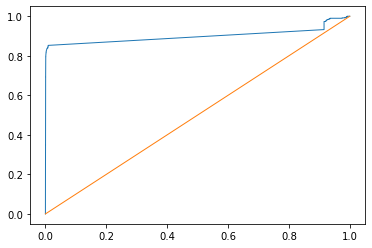

0.899804820272458


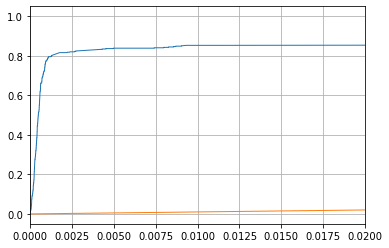

크기 2280880
비정상 489
[1.9981823e+00 9.9818230e-01 9.9648970e-01 ... 7.3544495e-04 7.3518703e-04
 6.7133317e-04]


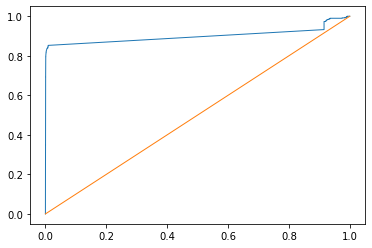

0.899804820272458


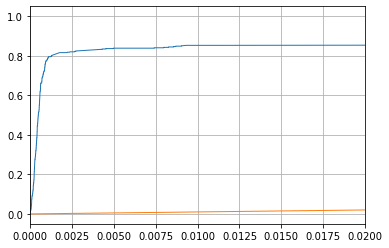

1%
fpr: 0.009996969817895265
tpr:  0.852760736196319

417 2257594 22797 72
precision:  0.01796329800982166
recall:  0.852760736196319
F-measure: 0.03518541552620573
MCC: 0.12293073011018447
0.5%
fpr: 0.004997827127014622
tpr:  0.8384458077709611

410 2268994 11397 79
precision:  0.03472516303887525
recall:  0.8384458077709611
F-measure: 0.06668834629874935
MCC: 0.17003715391509744
0.1%
fpr: 0.000998951495598781
tpr:  0.7791411042944786

381 2278113 2278 108
precision:  0.14328694998119593
recall:  0.7791411042944786
F-measure: 0.24205842356796073
MCC: 0.3338574461506547
p_plus:  0.00034236600816637446
p_minus:  0.9996576339918336
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400

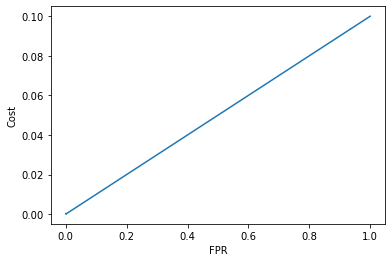

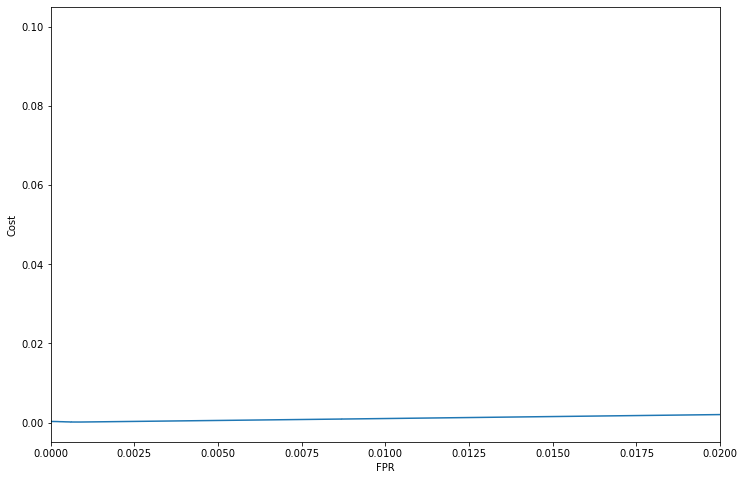

FPR at minimum cost: 0.0009191406210601603
0.00016245620044682925
377 2278295 2096 112
precision:  0.15244642135058634
recall:  0.7709611451942741
F-measure: 0.2545577036954503
MCC: 0.3425673121127304


In [2]:

import os
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, BatchNormalization, ReLU, LSTM
from tensorflow.keras.layers import TimeDistributed
from tensorflow import keras
from tensorflow.keras import layers

import time
import itertools
import pandas as pd
import glob
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt
import gc


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    print(e)

total_df = pd.read_csv("to_mrmr.csv")

window_n = 5
stride = 12
window_size = 24
normal_scores = []
feature = [
           'rec_day2',
           'rec_week2',
           'rec_2week2',
           'rec_month2' ]






total_data = total_df.dropna().loc[:, ['label'] + feature].to_numpy()

del total_df
gc.collect()


where_abnormal = np.argwhere(total_data[:,0]==1)


#assert(False)




normal_data = []

for i in range(0,total_data.shape[0]-(window_size + (window_n-1)*stride )):
  ws = []
  for w_n in range(window_n):
    ws.append(total_data[(w_n*stride)+ i:(w_n*stride) + i +window_size])
  ws = np.array(ws)
  if np.all(ws[:,:,0] == 0):
    normal_data.append(ws[:, :, 1:])
  #if i == 1000:
  #  break;

normal_data = np.array(normal_data).astype(np.float32)

#print(normal_data.shape)
    
#assert(False)
#good_score.append(kl_divergence(w_p, normal_q))
abnormal_data = []

print(where_abnormal.shape)
for ab in where_abnormal:
  i = ab[0] + 1 - window_size - stride * (window_n-1)
  if (i < 0):
    continue
  ws = []
  for w_n in range(window_n):
    ws.append(total_data[(w_n*stride)+ i:(w_n*stride) + i +window_size, 1:])
  ws = np.array(ws)
  abnormal_data.append(ws)

abnormal_data = np.array(abnormal_data).astype(np.float32)

del total_data
gc.collect()

random_idx = np.arange(normal_data.shape[0])
np.random.shuffle(random_idx)
normal_data = normal_data[random_idx]

random_idx = np.arange(abnormal_data.shape[0])
np.random.shuffle(random_idx)
abnormal_data = abnormal_data[random_idx]

del random_idx

cut = normal_data.shape[0]//5

training_x = normal_data[:cut]
training_y = [[1, 0] for _ in range(cut)]
duplicate_weight = 200

print(training_x.shape)
print(abnormal_data.shape)

for _ in range(duplicate_weight):
  training_x = np.concatenate([training_x, abnormal_data[:abnormal_data.shape[0]//2]], axis = 0)
training_y = training_y + [[0, 1] for _ in range(training_x.shape[0]-len(training_y))]

training_y = np.array(training_y)


test_x = normal_data[cut:]
test_y = [[1, 0] for _ in range(normal_data.shape[0]-cut)]


test_x = np.concatenate([test_x, abnormal_data[abnormal_data.shape[0]//2:]], axis = 0)
test_y = test_y + [[0, 1] for _ in range(test_x.shape[0]-len(test_y))]

test_y = np.array(test_y)

print(training_x.shape)
print(training_y.shape)
print(test_x.shape)
print(test_y.shape)

del normal_data, abnormal_data
gc.collect()


def get_data():
    global training_x, training_y
    random_idx = np.arange(training_x.shape[0])
    np.random.shuffle(random_idx)
    training_x = training_x[random_idx]
    training_y = training_y[random_idx]
    for i in range(training_x.shape[0]):
      x = training_x[i].astype(np.float32)
      y = training_y[i].astype(np.int8)
      yield (x, y)

training_set = tf.data.Dataset.from_generator(get_data, (tf.float32, np.int8), ((window_n, window_size, len(feature)), (2)))

training_set = training_set.batch(256)



def get_test_data():
    global test_x, test_y
    for i in range(test_x.shape[0]):
      x = test_x[i].astype(np.float32)
      y = test_y[i].astype(np.int8)
      yield (x, y)

test_set = tf.data.Dataset.from_generator(get_test_data, (tf.float32, np.int8), ((window_n, window_size, len(feature)), (2)))

test_set = test_set.batch(256)





l2param=0.001

model = Sequential()
model.add(TimeDistributed(
  Conv1D(16, 4, padding = "valid",
         kernel_regularizer=tf.keras.regularizers.l2(l2param))
  ))

#model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(ReLU()))
model.add(TimeDistributed(MaxPooling1D(2)))
#model.add(TimeDistributed(Dropout(0.4)))
#model.add(TimeDistributed(Conv1D(16, 3, padding = "valid")))
#model.add(TimeDistributed(BatchNormalization()))
#model.add(TimeDistributed(ReLU()))
#model.add(TimeDistributed(MaxPooling1D(2)))
#model.add(TimeDistributed(Dropout(0.4)))

model.add(TimeDistributed(Flatten()))

#model.add(LSTM(units=256, return_sequences=True, dropout=0.5))
model.add(LSTM(units=256,
              kernel_regularizer=tf.keras.regularizers.l2(l2param)
              ))
model.add(Dense(2, activation='sigmoid',
                kernel_regularizer=tf.keras.regularizers.l2(l2param)))

model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0005), metrics=['accuracy'])



start = time.time()
model.fit(training_set, epochs=10, verbose=0)
end = time.time()

print("training time (sec): ", end - start)
print("training time per sample (sec): ", (end-start)/(training_x.shape[0]*10))

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

start = time.time()
result = model.predict(test_set)[:, 1]
end = time.time()

print("reference_time (sec): ", end-start)
print("reference_time per sample: ", (end-start)/test_x.shape[0])

#plt.figure()
#plt.plot(result[:100])
#plt.show()
new_label = test_y[:,1]
#new_label = 1-label
#new_label = label.astype(np.int)

#print(result[1500:1600])
#print(new_label[1500:1600])
fpr, tpr, thesholds = roc_curve(new_label, result)
print(thesholds)
plt.figure()
plt.plot(fpr, tpr, lw=1)

mean_fpr = np.linspace(0, 1, 100)
plt.plot(mean_fpr, mean_fpr, lw=1)
plt.show()
print(auc(fpr, tpr))

plt.figure()
plt.plot(fpr, tpr, lw=1)

mean_fpr = np.linspace(0, 1, 100)
plt.xlim([0, 0.02])
plt.grid("on")
plt.plot(mean_fpr, mean_fpr, lw=1)
plt.show()







import itertools
import pandas as pd
import glob
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import scale
from sklearn import mixture
from sklearn.naive_bayes import GaussianNB
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt



print('크기', len(new_label))
print('비정상', sum(new_label))
fpr, tpr, thesholds = roc_curve(new_label, result)
print(thesholds)
plt.figure()
plt.plot(fpr, tpr, lw=1)
mean_fpr = np.linspace(0, 1, 100)
plt.plot(mean_fpr, mean_fpr, lw=1)
plt.show()
print(auc(fpr, tpr))

plt.figure()
plt.plot(fpr, tpr, lw=1)

mean_fpr = np.linspace(0, 1, 100)
plt.xlim([0, 0.02])
plt.grid("on")
plt.plot(mean_fpr, mean_fpr, lw=1)
plt.show()

print("1%")
for i in range(len(fpr)):
  if fpr[i] > 0.01: #1%
    if (i > 0): i -= 1
    break;
print("fpr:", fpr[i])
print("tpr: ",tpr[i])
print()
predicted = result >= thesholds[i]
TP = int(sum(np.logical_and(new_label==1,  predicted==1)))
TN = int(sum(np.logical_and(new_label==0,  predicted==0)))
FP = int(sum(np.logical_and(new_label==0,  predicted==1)))
FN = int(sum(np.logical_and(new_label==1,  predicted==0)))

print(TP,TN,FP,FN)

Precision = TP/(TP+FP)
Recall = TP/(TP+FN)

print("precision: ", Precision)
print("recall: ", Recall)
print("F-measure:", (2*Precision*Recall)/(Precision+Recall+1e-7))
print("MCC:", (TP*TN-FP*FN)/(np.sqrt((TP+FN)*(TP+FP)*(TN+FP)*(TN+FN)*1.0))+1e-7)

print("0.5%")
for i in range(len(fpr)):
  if fpr[i] > 0.005: #0.5%
    if (i > 0): i -= 1
    break;
print("fpr:", fpr[i])
print("tpr: ",tpr[i])
print()
predicted = result >= thesholds[i]
TP = int(sum(np.logical_and(new_label==1,  predicted==1)))
TN = int(sum(np.logical_and(new_label==0,  predicted==0)))
FP = int(sum(np.logical_and(new_label==0,  predicted==1)))
FN = int(sum(np.logical_and(new_label==1,  predicted==0)))

print(TP,TN,FP,FN)

Precision = TP/(TP+FP)
Recall = TP/(TP+FN)

print("precision: ", Precision)
print("recall: ", Recall)
print("F-measure:", (2*Precision*Recall)/(Precision+Recall+1e-7))
print("MCC:", (TP*TN-FP*FN)/(np.sqrt((TP+FN)*(TP+FP)*(TN+FP)*(TN+FN)*1.0))+1e-7)

print("0.1%")
for i in range(len(fpr)):
  if fpr[i] > 0.001: #0.1%
    if (i > 0): i -= 1
    break;
print("fpr:", fpr[i])
print("tpr: ",tpr[i])
print()
predicted = result >= thesholds[i]
TP = int(sum(np.logical_and(new_label==1,  predicted==1)))
TN = int(sum(np.logical_and(new_label==0,  predicted==0)))
FP = int(sum(np.logical_and(new_label==0,  predicted==1)))
FN = int(sum(np.logical_and(new_label==1,  predicted==0)))

print(TP,TN,FP,FN)

Precision = TP/(TP+FP)
Recall = TP/(TP+FN)

print("precision: ", Precision)
print("recall: ", Recall)
print("F-measure:", (2*Precision*Recall)/(Precision+Recall+1e-7))
print("MCC:", (TP*TN-FP*FN)/(np.sqrt((TP+FN)*(TP+FP)*(TN+FP)*(TN+FN)*1.0))+1e-7)


#총 데이터 중 정상 데이터 비율
normal_n = 2855614
#총 데이터중 비정상 데이터 비율
abnormal_n = 978

p_plus = abnormal_n/(normal_n+abnormal_n)
p_minus = normal_n/(normal_n+abnormal_n)

print("p_plus: ", p_plus)
print("p_minus: ", p_minus)
w_FNR = 0.9
w_FPR = 0.1

cost = []
for i in range(len(fpr)):
  if i % 100 == 0:
    print(i)
  predicted = result >= thesholds[i]
  TP = np.sum(np.logical_and(new_label==1,  predicted==1))
  TN = np.sum(np.logical_and(new_label==0,  predicted==0))
  FP = np.sum(np.logical_and(new_label==0,  predicted==1))
  FN = np.sum(np.logical_and(new_label==1,  predicted==0))
  FNR = FN/(FN+TP) #비정상 데이터중 미알람 비율
  FPR = FP/(FP+TN) #정상 데이터중 비정상 알람 비율
  
  cost.append(w_FNR*FNR*p_plus + w_FPR*FPR*p_minus)


plt.plot(fpr, cost)
plt.xlabel("FPR")
plt.ylabel("Cost")
plt.show()

plt.figure(figsize=[12, 8])
plt.plot(fpr, cost)
plt.xlabel("FPR")
plt.ylabel("Cost")
plt.xlim([0, 0.02])
#plt.ylim([0, cost[400]])
plt.show()

print("FPR at minimum cost:", fpr[np.argmin(cost)])
print(np.amin(cost))

i = np.argmin(cost)
predicted = result >= thesholds[i]
TP = int(sum(np.logical_and(new_label==1,  predicted==1)))
TN = int(sum(np.logical_and(new_label==0,  predicted==0)))
FP = int(sum(np.logical_and(new_label==0,  predicted==1)))
FN = int(sum(np.logical_and(new_label==1,  predicted==0)))

print(TP,TN,FP,FN)

Precision = TP/(TP+FP)
Recall = TP/(TP+FN)


print("precision: ", Precision)
print("recall: ", Recall)
print("F-measure:", (2*Precision*Recall)/(Precision+Recall+1e-7))
print("MCC:", (TP*TN-FP*FN)/(np.sqrt((TP+FN)*(TP+FP)*(TN+FP)*(TN+FN)*1.0))+1e-7)